# Data exploration of geoclim and GBS sequencing data from wild coffee tree samples

## About the data
### Source
Hamon P, Grover CE, Davis AP, Rakotomalala JJ, Raharimalala NE, Albert VA, Sreenath HL, Stoffelen P, Mitchell SE, Couturon E, Hamon S, de Kochko A, Crouzillat D, Rigoreau M, Sumirat U, Akaffou S, Guyot R. Genotyping-by-sequencing provides the first well-resolved phylogeny for coffee (Coffea) and insights into the evolution of caffeine content in its species: GBS coffee phylogeny and the evolution of caffeine content. Mol Phylogenet Evol. 2017 Apr;109:351-361. doi: 10.1016/j.ympev.2017.02.009. Epub 2017 Feb 16. PMID: 28212875.

### Metadata
Metadata table in [data directory](coffeaPhyloGeo/data/geoclim/geospatial/coff_madag_species_summary.xlsx)

**Genetic data :**
GBS/Rad-Seq from nuclear DNA. Data cleaning, ref-genome alignement + SNP concat #TODO

**geoclim data :**
GPS positions available in metadata table. To use to extract information on the [Madaclim](https://madaclim.cirad.fr/) database.

---

**All required imports and utils**

In [87]:
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from definitions import *
import geopandas as gpd
from shapely.geometry import Point
import calendar
import re
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import colors

## Climate data extraction

### Paths and file configs
See definitions.py for dir paths + config.yaml ref

In [88]:
# File names
print("\n".join([METADATA_RAW, GPS_ALL,GPS_GBS_ONLY, MADACLIM_CURRENT_TIF]))

coff_madag_species_summary.xlsx
species_locations_all_positions.csv
species_locations_gbs_only.csv
madaclim_current.tif


### GPS position extraction from metadata + cleaning
Generate 2 csv files for 2 subsets using Pandas :
- all specimens WITH GPS positions (df_gps_all)
- only specimens with BOTH GPS and SNP.fasta (df_gbs_only)

In [89]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")
df = df.dropna(how="all")
df.head()

,Species,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude,Species code,Population code
0,C.abbayesii,C_abbayesii_A601,Millotii,1.25,-24.7541,46.8624,ABA,A601
1,C.ambodirianenis,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.9433,AMB,A572
2,C.ambongensis,C_ambongensis,Baracoffea,1.16,-15.5745833,46.4198056,AMBON,BR071
3,C.ankaranensis,C_ankaranensis_A525,Multiflorae \n,1.17,-12.9491,49.5433,ANK1,A525
4,C.ankaranensis,-,Multiflorae \n,1.17,-12.8491,49.5433,ANK2,A808


**Note for later** Use madaclim to impute missing gps POS on samples : 
- RNF785
- APD3096
- A1013

In [90]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")

# Remove blank rows
df = df.dropna(how="all")
df["GBS sequence"] = df["GBS sequence"].str.rstrip()    #* \n still present after stripping

# Remove \n in Botanical series
df = df.replace(r"\n","", regex=True)

# Converting to proper NaN and reordering
df = df.replace({"-": np.nan, "NO POSITION": np.nan})
df = df[["Species", "Species code", "Population code", "GBS sequence", "Botanical series", "Genome size (2C. pg)", "Latitude", "Longitude"]]
# Remove NO from AND2 species
df["Longitude"] = df["Longitude"].str.replace("NO ", "")
df["Longitude"] = df["Longitude"].str.replace(",", ".").astype(float)

df.head()


,Species,Species code,Population code,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude
0,C.abbayesii,ABA,A601,C_abbayesii_A601,Millotii,1.25,-24.7541,46.862400
1,C.ambodirianenis,AMB,A572,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.943300
2,C.ambongensis,AMBON,BR071,C_ambongensis,Baracoffea,1.16,-15.5745833,46.419806
3,C.ankaranensis,ANK1,A525,C_ankaranensis_A525,Multiflorae,1.17,-12.9491,49.543300
4,C.ankaranensis,ANK2,A808,NaN,Multiflorae,1.17,-12.8491,49.543300


In [91]:
# Keep df for all species WITH GPS positions and reorder
df_gps_all = df.copy()
df_gps_all = df_gps_all.dropna(subset=["Latitude", "Longitude"])
print(f"Number of samples for all specimens WITH GPS : {len(df_gps_all)}")
df_gps_all = df_gps_all.reset_index().drop(columns=["index"])

Number of samples for all specimens WITH GPS : 51


In [92]:
# Clean for missing GBS sequences
df_gbs_only = df_gps_all.dropna().copy()
print(f"Number of samples for specimens with BOTH GPS AND genetic data : {len(df_gbs_only)}")
df_gbs_only = df_gbs_only.reset_index().drop(columns=["index"])

Number of samples for specimens with BOTH GPS AND genetic data : 41


**Save as csv to data/geoclim/geospatial/**

In [93]:
# Save cleaned data to csv in geospatial dir
# df_gps_all.to_csv(GEOSPATIAL_DIR / GPS_ALL, index=False)  # All positions available
# df_gbs_only.to_csv(GEOSPATIAL_DIR / GPS_GBS_ONLY, index=False)    # Species with both gbs AND positions

### Raster file basic manipulations

In [94]:
# Open raster file
raster_mada = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_mada.closed)}")


File opened ? True


In [95]:
# Check for dtypes
if len(set(raster_mada.dtypes)) > 1 :
    print(f"Raster file {MADACLIM_CURRENT_TIF} has more than one dtypes")
    print(set(raster_mada.dtypes))
else:
    print(f"Raster file {MADACLIM_CURRENT_TIF} has only {set(raster_mada.dtypes)}")    

# Get dict for all band dtypes combinations
bands_types = {i: dtype for i, dtype in zip(raster_mada.indexes, raster_mada.dtypes)}
# print(bands_types)

Raster file madaclim_current.tif has only {'int16'}


In [96]:
# Number of bands total
print(f"{MADACLIM_CURRENT_TIF} has {len(raster_mada.indexes)} bands")

madaclim_current.tif has 70 bands


In [97]:
# Get CRS + bounds
print(f"CRS of {MADACLIM_CURRENT_TIF} : {raster_mada.crs}")

CRS of madaclim_current.tif : EPSG:32738


In [98]:
raster_mada.bounds

BoundingBox(left=298000.0, bottom=7155000.0, right=1101000.0, top=8683000.0)

In [99]:
# band1
band1 = raster_mada.read(1)
band1[raster_mada.height // 2, raster_mada.width // 2]

120

In [100]:
#nodata value
raster_mada.nodata

-32768.0

In [101]:
raster_mada.read(1)

array([[-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       ...,
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768],
       [-32768, -32768, -32768, ..., -32768, -32768, -32768]], dtype=int16)

#### Plotting individual bands and distributions

Example with band 37 = bio1_Mean Annual Temperature

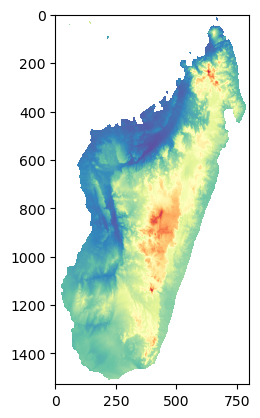

<AxesSubplot: >

In [102]:
# bio1_Annual Mean Temp associated with band37 (see example in section below)
rasterio.plot.show(raster_mada.read(37, masked=True), cmap="Spectral")

Underneat the hood, this is just a masked numpy array that is calling the imshow() method on an axes object.

In [103]:
raster_mada.read(1, masked=True).compressed()[:5]

array([209, 208, 205, 204, 204], dtype=int16)

We could than apply the compressed method to the raster.read(band#) array and plot a more customized version

Text(0.5, 1.0, 'Number of dry months per year\n')

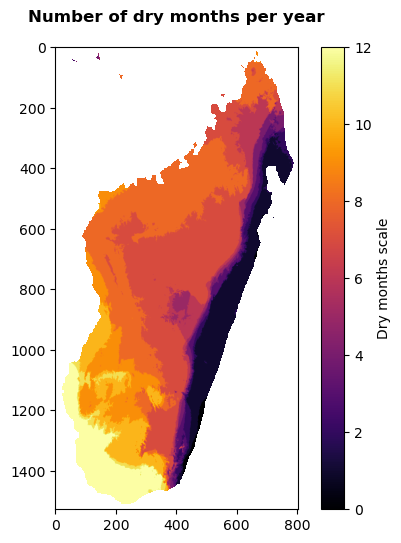

In [104]:
# For number of dry months
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(raster_mada.read(70, masked=True), cmap="inferno", norm="linear")
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Dry months scale")
plt.title("Number of dry months per year\n", weight="bold")

Again, same for distributions histograms

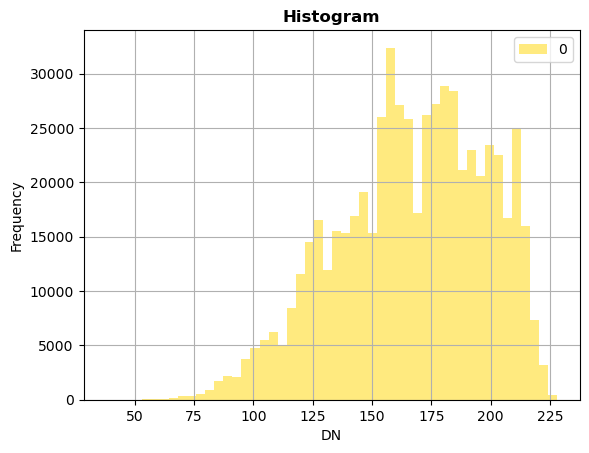

In [105]:
# With rasterio
fig, ax = plt.subplots()

rasterio.plot.show_hist(
    raster_mada.read(1, masked=True), bins=50, stacked=False, alpha=0.5,
    histtype='stepfilled', title="Histogram", label="0", ax=ax,
)

Text(0.5, 1.0, 'Distribution data for band37 (bio1)')

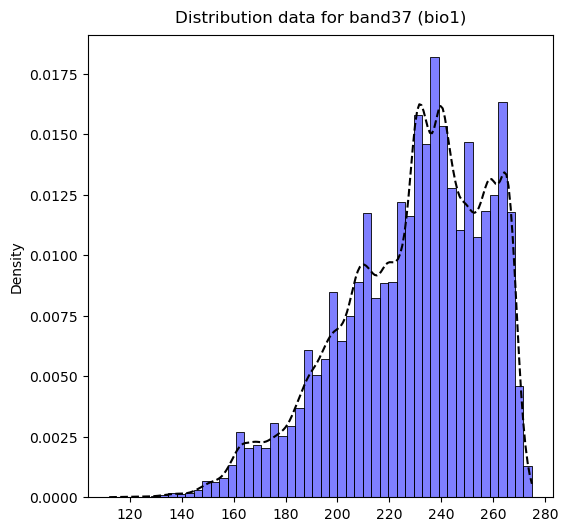

In [106]:
# With seaborn
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.histplot(
    data=raster_mada.read(37, masked=True).compressed(),
    color="blue",
    bins=50,
    ax=ax,
    kde=True, stat="density",
    line_kws={"linestyle" : "--"}
)
ax.lines[0].set_color("black")
ax.set_title("Distribution data for band37 (bio1)", pad=10)

Combining both side by side

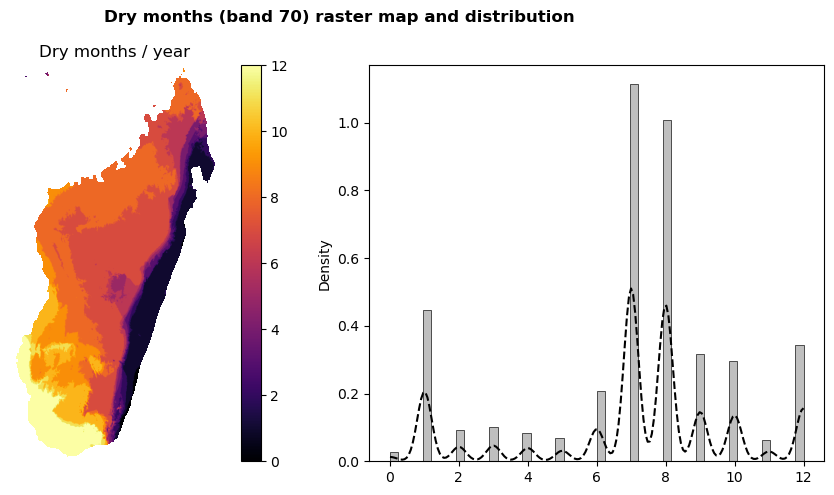

In [107]:
# Selecting the band
band_num = 70
band = raster_mada.read(band_num, masked=True)

# Plotting both map and distributions of raster values
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Raster map
im = axes[0].imshow(band, cmap="inferno", norm="linear")
cbar = plt.colorbar(im)
axes[0].set_title("Dry months / year")
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].axis("off")

# Pixel vals distributions
sns.histplot(
    data=band.compressed(), color="grey", bins=50, ax=axes[1], 
    kde=True, stat="density",
    line_kws={"linestyle" : "--"}
)
axes[1].lines[0].set_color("black")

fig.suptitle("Dry months (band 70) raster map and distribution", weight="bold")
fig.tight_layout()

### Defining the climate variables to get from raster

Get info for bioclim vars

In [108]:
# bioclim vars
def label_bioclim_vars():
    bio1_bio19 = [f"{k}_{v['longname']}" for k,v in config["bioclim_defs"].items()]
    bio_layers = {}
    for i, bio in enumerate(bio1_bio19, start=37):
        bio_layers[f"layer{i}"] = bio
    return bio_layers
label_bioclim_vars ()

{'layer37': 'bio1_Annual Mean Temperature',
 'layer38': 'bio2_Mean Diurnal Range(Mean(period max-min)',
 'layer39': 'bio3_Isothermality (bio2/bio7)',
 'layer40': 'bio4_Temperature Seasonality (C of V)',
 'layer41': 'bio5_Max Temperature of Warmest Period',
 'layer42': 'bio6_Min Temperature of Coldest Period',
 'layer43': 'bio7_Temperature Annual Range (5-6)',
 'layer44': 'bio8_Mean Temperature of Wettest Quarter',
 'layer45': 'bio9_Mean Temperature of Driest Quarter',
 'layer46': 'bio10_Mean Temperature of Warmest Quarter',
 'layer47': 'bio11_Mean Temperature of Coldest Quarter',
 'layer48': 'bio12_Annual Precipitation',
 'layer49': 'bio13_Precipitation of Wettest Period',
 'layer50': 'bio14_Precipitation of Driest Period',
 'layer51': 'bio15_Precipitation Seasonality(C of V)',
 'layer52': 'bio16_Precipitation of Wettest Quarter',
 'layer53': 'bio17_Precipitation of Driest Quarter',
 'layer54': 'bio18_Precipitation of Warmest Quarter',
 'layer55': 'bio19_Precipitation of Coldest Quarte

Get info for monthly vars

In [109]:
# Layers description for monthly vars
l1_12 = "Monthly minimum temperature (C x 10)"
l13_24 = "Monthly maximum temperature (C x 10)"
l25_36 = "Monthly total precipitation (mm.month-1)"
l56_67 = "Monthly potential evapotranspiration (mm.month-1)"

In [110]:
def label_monthly_vars(description, first_layer):
    layers = {}
    monthly_vars = [f"{description}_{month}" for month in calendar.month_name[1:]]
    for i, month in enumerate(monthly_vars, start=first_layer):
        layers[f"layer{i}"] = month
    return layers

Get info for annual vars

In [111]:
l68 = {"layer68" : "Annual potential evapotranspiration (mm)"}
l69 = {"layer69" : "Annual climatic water deficit (mm)"}
l70 = {"layer70" : "Number of dry months in the year"}

Generate all vars dictionary

In [112]:
# Layers 1 to 12
mada_layers = {}
temp_layers = label_monthly_vars(l1_12, 1)
mada_layers.update(temp_layers)

# Layers 13 to 24
temp_layers = label_monthly_vars(l13_24, 13)
mada_layers.update(temp_layers)

# Layers 25 to 36
temp_layers = label_monthly_vars(l25_36, 25)
mada_layers.update(temp_layers)

# Layers 37 to 55 (bioclim)
temp_layers = label_bioclim_vars()
mada_layers.update(temp_layers)

# Layers 56 to 67
temp_layers = label_monthly_vars(l56_67, 56)
mada_layers.update(temp_layers)
mada_layers.update(l68)
mada_layers.update(l69)
mada_layers.update(l70)

mada_layers

{'layer1': 'Monthly minimum temperature (C x 10)_January',
 'layer2': 'Monthly minimum temperature (C x 10)_February',
 'layer3': 'Monthly minimum temperature (C x 10)_March',
 'layer4': 'Monthly minimum temperature (C x 10)_April',
 'layer5': 'Monthly minimum temperature (C x 10)_May',
 'layer6': 'Monthly minimum temperature (C x 10)_June',
 'layer7': 'Monthly minimum temperature (C x 10)_July',
 'layer8': 'Monthly minimum temperature (C x 10)_August',
 'layer9': 'Monthly minimum temperature (C x 10)_September',
 'layer10': 'Monthly minimum temperature (C x 10)_October',
 'layer11': 'Monthly minimum temperature (C x 10)_November',
 'layer12': 'Monthly minimum temperature (C x 10)_December',
 'layer13': 'Monthly maximum temperature (C x 10)_January',
 'layer14': 'Monthly maximum temperature (C x 10)_February',
 'layer15': 'Monthly maximum temperature (C x 10)_March',
 'layer16': 'Monthly maximum temperature (C x 10)_April',
 'layer17': 'Monthly maximum temperature (C x 10)_May',
 'laye

In [113]:
len(mada_layers)

70

Example to find layer# of Mean Annual temperature

In [114]:
for k,v in mada_layers.items():
    if re.search("[Aa]nnual Mean", mada_layers[k]):
        print(k, v)

layer37 bio1_Annual Mean Temperature


### Creating Point objects for each specimen

Subset df

In [115]:
df_gbs = df_gbs_only[["Species code", "Genome size (2C. pg)", "Longitude", "Latitude"]].copy()
print(f"df_gbs (both gps + genetic data) has {len(df_gbs)} specimens")
df_gbs = df_gbs.set_index("Species code")
df_gbs.head()

df_gbs (both gps + genetic data) has 41 specimens


,Genome size (2C. pg),Longitude,Latitude
Species code,,,
ABA,1.25,46.862400,-24.7541
AMB,1.27,48.943300,-18.4522
AMBON,1.16,46.419806,-15.5745833
ANK1,1.17,49.543300,-12.9491
ARE,1.11,48.200000,-18.9333


Create shapely.Point objects from GPS coordinates

In [116]:
# Beware of lon/lat order in instance creation
points = [Point(float(row["Longitude"]), float(row["Latitude"])) for index, row in df_gbs.iterrows()]
points[0:10]

[<POINT (46.862 -24.754)>,
 <POINT (48.943 -18.452)>,
 <POINT (46.42 -15.575)>,
 <POINT (49.543 -12.949)>,
 <POINT (48.2 -18.933)>,
 <POINT (49.167 -12.733)>,
 <POINT (46.633 -25.017)>,
 <POINT (46.812 -16.315)>,
 <POINT (46.827 -16.296)>,
 <POINT (49.88 -13.35)>]

Create GeoPandas dataframe

In [117]:
# Original coordinates under GPS format aka epsg:4326
gdf_gbs = gpd.GeoDataFrame(df_gbs, geometry=points, crs=4326)
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry
Species code,,,,
ABA,1.25,46.862400,-24.7541,POINT (46.86240 -24.75410)
AMB,1.27,48.943300,-18.4522,POINT (48.94330 -18.45220)
AMBON,1.16,46.419806,-15.5745833,POINT (46.41981 -15.57458)
ANK1,1.17,49.543300,-12.9491,POINT (49.54330 -12.94910)
ARE,1.11,48.200000,-18.9333,POINT (48.20000 -18.93330)


Check CRS + transform to Madaclim_current.tif raster CRS

In [118]:
gdf_gbs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [119]:
gdf_gbs = gdf_gbs.to_crs(32738)
gdf_gbs.head()


,Genome size (2C. pg),Longitude,Latitude,geometry
Species code,,,,
ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023)
AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629)
AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406)
ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062)
ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321)


In [120]:
# to get the x/lon attribute of Point objects
gdf_gbs["geometry"].x.head()  #lon


Species code
ABA      688328.240325
AMB      916635.952187
AMBON    652237.905456
ANK1     993250.150336
ARE      837072.915024
dtype: float64

In [121]:
gdf_gbs.crs

<Derived Projected CRS: EPSG:32738>
Name: WGS 84 / UTM zone 38S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 42°E and 48°E, southern hemisphere between 80°S and equator, onshore and offshore. Madagascar.
- bounds: (42.0, -80.0, 48.0, 0.0)
Coordinate Operation:
- name: UTM zone 38S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [122]:
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry
Species code,,,,
ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023)
AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629)
AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406)
ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062)
ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321)


View points on raster map

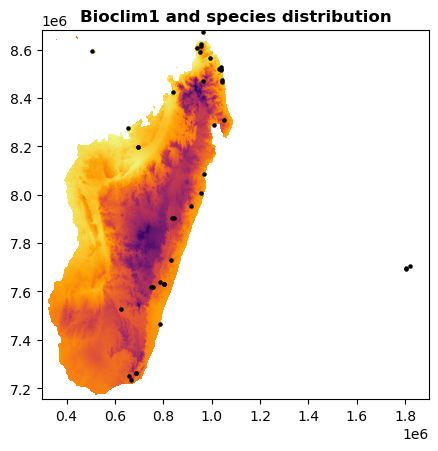

In [123]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_mada:

    fig, ax = plt.subplots()
    ax = rasterio.plot.show(raster_mada.read(1, masked=True), transform=raster_mada.transform, cmap="inferno", ax=ax, title="Bioclim1 and species distribution")
    # cbar = plt.colorbar(im)
    # cbar.ax.set_ylabel("bio1_Annual Mean Temperature")
    # plt.title("Bioclim1 and species distribution", weight="bold")
    # ax.set_aspect("equal")
    gdf_gbs.plot(ax=ax, color="black", markersize=5)


OK nice it works, we can improve visualization later. Still we see some outlier points that won't have any data (outgroups + others)

### Using GeoPandas with Rasterio to sample point data

In [175]:
# Open raster file
raster_mada = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_mada.closed)}")

File opened ? True


In [177]:
raster_mada.read(1, masked=True).shape

(1528, 803)

In [125]:
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry
Species code,,,,
ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023)
AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629)
AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406)
ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062)
ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321)


Extract for all coords + create cols on geodf

In [126]:
# Create a list of coordinates under EPSG:32738
coord_list = [(x,y) for x,y in zip(gdf_gbs["geometry"].x, gdf_gbs["geometry"].y)]
coord_list[0:5]
# print(len(coord_list))

[(688328.2403248843, 7260998.022932809),
 (916635.9521871379, 7955240.6291522365),
 (652237.9054559749, 8277614.406156755),
 (993250.1503363773, 8564104.062130136),
 (837072.9150244407, 7903496.320897499)]

In [127]:
# Slice first specimen for all raster layers
all_vals = [x for x in raster_mada.sample(coord_list)]
print(f"num specimens extracted : {len(all_vals)}")
all_vals[0]

num specimens extracted : 41


array([ 155,  195,  188,  171,  136,  122,  120,  124,  138,  173,  188,
        196,  276,  295,  288,  281,  266,  243,  235,  240,  259,  286,
        293,  297,   57,  181,  169,   73,   64,   73,   58,   57,   44,
        105,  175,  204,  215,  112,   63, 2597,  297,  120,  177,  238,
        186,  238,  180, 1260,  204,   44,   56,  484,  159,  484,  188,
         92,  125,  113,   94,   67,   50,   44,   47,   60,   92,  110,
        123, 1022,   77,    4], dtype=int16)

In [128]:
# Note to remove in df 2 outgroups since they have no data in the Madaclim db
print(f"Value of 'no data' in raster file : {raster_mada.nodata}")
all_vals[-3:]

Value of 'no data' in raster file : -32768.0


[array([ 173,  211,  206,  193,  163,  146,  142,  145,  155,  194,  203,
         213,  269,  295,  289,  281,  266,  250,  236,  240,  251,  285,
         294,  296,   71,  381,  394,  153,  100,  110,  110,  111,   81,
         171,  226,  379,  224,   92,   59, 2478,  296,  142,  154,  245,
         194,  247,  193, 2287,  394,   71,   64,  928,  302,  776,  331,
          93,  132,  121,  103,   75,   58,   49,   52,   62,  101,  117,
         131, 1099,   22,    1], dtype=int16),
 array([-32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
     

We have all the data in a list of 41 (each specimens) arrays each containing 70 elements (each climvars)

We need to get this information ordered unto the GeoPandas df

In [129]:
# Add all_vals arrays in single col in df
gdf_gbs["all_layers"] = all_vals
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers
Species code,,,,,
ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ..."
AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ..."
AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ..."
ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ..."
ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ..."


In [130]:
len(all_vals)

41

In [131]:
# Adding each layer has a column (layer num + units) for each specimen
for i, (k, v) in enumerate(mada_layers.items()):
    for val, specimen in zip(all_vals, gdf_gbs.index.to_list()):
        gdf_gbs.loc[specimen, f"{k} : {v}"] = val[i]
        

In [132]:
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
Species code,,,,,,,,,,,,,,,,,,,,,
ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ...",155.0,195.0,188.0,171.0,136.0,...,50.0,44.0,47.0,60.0,92.0,110.0,123.0,1022.0,77.0,4.0
AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ...",157.0,203.0,199.0,185.0,164.0,...,61.0,47.0,48.0,56.0,92.0,109.0,121.0,1041.0,16.0,1.0
AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ...",222.0,236.0,238.0,235.0,217.0,...,107.0,93.0,102.0,120.0,164.0,164.0,156.0,1709.0,849.0,8.0
ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ...",206.0,228.0,227.0,224.0,211.0,...,99.0,83.0,85.0,96.0,137.0,147.0,146.0,1482.0,501.0,8.0
ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ...",130.0,176.0,166.0,153.0,126.0,...,48.0,40.0,41.0,50.0,84.0,95.0,102.0,891.0,61.0,4.0


In [133]:
# Compare with all layers : OK
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
Species code,,,,,,,,,,,,,,,,,,,,,
ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ...",155.0,195.0,188.0,171.0,136.0,...,50.0,44.0,47.0,60.0,92.0,110.0,123.0,1022.0,77.0,4.0
AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ...",157.0,203.0,199.0,185.0,164.0,...,61.0,47.0,48.0,56.0,92.0,109.0,121.0,1041.0,16.0,1.0
AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ...",222.0,236.0,238.0,235.0,217.0,...,107.0,93.0,102.0,120.0,164.0,164.0,156.0,1709.0,849.0,8.0
ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ...",206.0,228.0,227.0,224.0,211.0,...,99.0,83.0,85.0,96.0,137.0,147.0,146.0,1482.0,501.0,8.0
ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ...",130.0,176.0,166.0,153.0,126.0,...,48.0,40.0,41.0,50.0,84.0,95.0,102.0,891.0,61.0,4.0


Removing the 2 last rows (outgroups) since they only have nodata values (positions out of Madaclim db)

In [134]:
print(f"Value of 'no data' in raster file : {raster_mada.nodata}")
gdf_gbs.tail(3) # See outgroups


Value of 'no data' in raster file : -32768.0


,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
Species code,,,,,,,,,,,,,,,,,,,,,
AND2,1.2,47.942000,-21.40083,POINT (805033.840 7630631.025),"[173, 211, 206, 193, 163, 146, 142, 145, 155, ...",173.0,211.0,206.0,193.0,163.0,...,58.0,49.0,52.0,62.0,101.0,117.0,131.0,1099.0,22.0,1.0
MAU,0.96,57.433333,-20.416667,POINT (1804938.104 7692467.997),"[-32768, -32768, -32768, -32768, -32768, -3276...",-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
MYR,1.07,57.583333,-20.308333,POINT (1821822.952 7703446.045),"[-32768, -32768, -32768, -32768, -32768, -3276...",-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0


Counting how many *nodata* points there are in the df

In [135]:
# Get number of cols that are not raster layers
l1_index = len(gdf_gbs.columns) - len(mada_layers)
print(f"Index num of Layer1 in df = {l1_index}")

Index num of Layer1 in df = 5


In [136]:
# Total number of elements
total_nodata = gdf_gbs.iloc[:, l1_index:][gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata].dropna().count().sum()
print(f"There are {total_nodata} specimens datapoints of value {raster_mada.nodata}")
print(f"So probably {int(280/len(mada_layers))} (280nodata / #layers) specimens to remove")

There are 280 specimens datapoints of value -32768.0
So probably 4 (280nodata / #layers) specimens to remove


In [137]:
# Get list of indexes with nodata values (from raster convention)
nodata_indexes = gdf_gbs.iloc[:, l1_index:][gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata].dropna().index.to_list()

# Drop them they are all outliers in the sense that all 70 layers are nodata
gdf_gbs.iloc[:, l1_index:][gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata].dropna()

,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,layer6 : Monthly minimum temperature (C x 10)_June,layer7 : Monthly minimum temperature (C x 10)_July,layer8 : Monthly minimum temperature (C x 10)_August,layer9 : Monthly minimum temperature (C x 10)_September,layer10 : Monthly minimum temperature (C x 10)_October,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
Species code,,,,,,,,,,,,,,,,,,,,,
MAC,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
RES1,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
MAU,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
MYR,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0


In [138]:
gdf_gbs = gdf_gbs.drop(nodata_indexes)

In [139]:
# Sanity check
if not [ele for ele in (gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata).any() if ele is True]:
    print("OK, no more 'nodata'")
len(gdf_gbs)

OK, no more 'nodata'


37

In [140]:
# Convert Genome size and Latitude to floats
gdf_gbs["Genome size (2C. pg)"] = gdf_gbs["Genome size (2C. pg)"].astype(float)
gdf_gbs["Latitude"] = gdf_gbs["Latitude"].astype(float)

### Environmental data extraction

In [141]:
#TODO

**DATA TRANSFORMATION INFORMATION:**

[Madaclim methods for climate db](https://madaclim.cirad.fr/methods-climate/)

## Climate data exploration

### Distributions per layer set

**Layers description reminder**

- layers1_12 ---> Monthly minimum temperature (C x 10)
- l13_24 ---> Monthly maximum temperature (C x 10)
- l25_36 ---> Monthly total precipitation (mm.month-1)
- l37_55 ---> bioclim
- l56_67 ---> Monthly potential evapotranspiration (mm.month-1)
- l68 ---> Annual potential evapotranspiration (mm)
- l69 ---> Annual climatic water deficit (mm)
- l70 ---> Number of dry months in the year

In [142]:
# Hardcoded
mada_layers_list = [d for d in mada_layers.items()]
layers1_12 = mada_layers_list[0:12]
layers13_24 = mada_layers_list[12:24]
layers25_36 = mada_layers_list[24:36]
layers37_55 = mada_layers_list[36:55]
layers56_67 = mada_layers_list[55:67]
layer68 = [mada_layers_list[67]]
layer69 = [mada_layers_list[68]]
layer70 = [mada_layers_list[69]]


In [143]:
# Same format as df
def get_layers(layers : dict, start : int, end=None):
    if end is None:
        end = start
    if start <1 :
        raise ValueError("Non-zero indexing for layers")
    elif end > len(layers):
        raise ValueError("Select a maximum that is within the range of layers")
    elif start > end:
        raise ValueError("Start layer must come before end layer")
    else :         
        selected_layers = []
        for i, (k, v) in enumerate(layers.items(), start=1):
            if i >= start and i <= end:
                selected_layers.append(f"{k} : {v}")
        return selected_layers

In [144]:
# Example for layers 68 to 70
print(get_layers(mada_layers, 68, 70))
print(f"\nThere are {len(mada_layers)} layers")

['layer68 : Annual potential evapotranspiration (mm)', 'layer69 : Annual climatic water deficit (mm)', 'layer70 : Number of dry months in the year']

There are 70 layers


In [145]:
# Specimens + positions cols
gdf_gbs.columns.to_list()[0:4]

['Genome size (2C. pg)', 'Longitude', 'Latitude', 'geometry']

In [146]:
# Subset df for layers 1 to 12
monthly_min = gdf_gbs.columns.to_list()[: l1_index] + get_layers(mada_layers, 1, 12)

gdf_gbs[monthly_min].head()

,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,layer6 : Monthly minimum temperature (C x 10)_June,layer7 : Monthly minimum temperature (C x 10)_July,layer8 : Monthly minimum temperature (C x 10)_August,layer9 : Monthly minimum temperature (C x 10)_September,layer10 : Monthly minimum temperature (C x 10)_October,layer11 : Monthly minimum temperature (C x 10)_November,layer12 : Monthly minimum temperature (C x 10)_December
Species code,,,,,,,,,,,,,,,,,
ABA,1.25,46.862400,-24.754100,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ...",155.0,195.0,188.0,171.0,136.0,122.0,120.0,124.0,138.0,173.0,188.0,196.0
AMB,1.27,48.943300,-18.452200,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ...",157.0,203.0,199.0,185.0,164.0,149.0,142.0,139.0,144.0,179.0,194.0,203.0
AMBON,1.16,46.419806,-15.574583,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ...",222.0,236.0,238.0,235.0,217.0,199.0,191.0,193.0,205.0,237.0,238.0,238.0
ANK1,1.17,49.543300,-12.949100,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ...",206.0,228.0,227.0,224.0,211.0,192.0,186.0,188.0,194.0,221.0,226.0,228.0
ARE,1.11,48.200000,-18.933300,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ...",130.0,176.0,166.0,153.0,126.0,107.0,109.0,107.0,114.0,152.0,164.0,175.0


In [147]:
gdf_gbs.iloc[:,l1_index:].columns.to_list()

['layer1 : Monthly minimum temperature (C x 10)_January',
 'layer2 : Monthly minimum temperature (C x 10)_February',
 'layer3 : Monthly minimum temperature (C x 10)_March',
 'layer4 : Monthly minimum temperature (C x 10)_April',
 'layer5 : Monthly minimum temperature (C x 10)_May',
 'layer6 : Monthly minimum temperature (C x 10)_June',
 'layer7 : Monthly minimum temperature (C x 10)_July',
 'layer8 : Monthly minimum temperature (C x 10)_August',
 'layer9 : Monthly minimum temperature (C x 10)_September',
 'layer10 : Monthly minimum temperature (C x 10)_October',
 'layer11 : Monthly minimum temperature (C x 10)_November',
 'layer12 : Monthly minimum temperature (C x 10)_December',
 'layer13 : Monthly maximum temperature (C x 10)_January',
 'layer14 : Monthly maximum temperature (C x 10)_February',
 'layer15 : Monthly maximum temperature (C x 10)_March',
 'layer16 : Monthly maximum temperature (C x 10)_April',
 'layer17 : Monthly maximum temperature (C x 10)_May',
 'layer18 : Monthly max

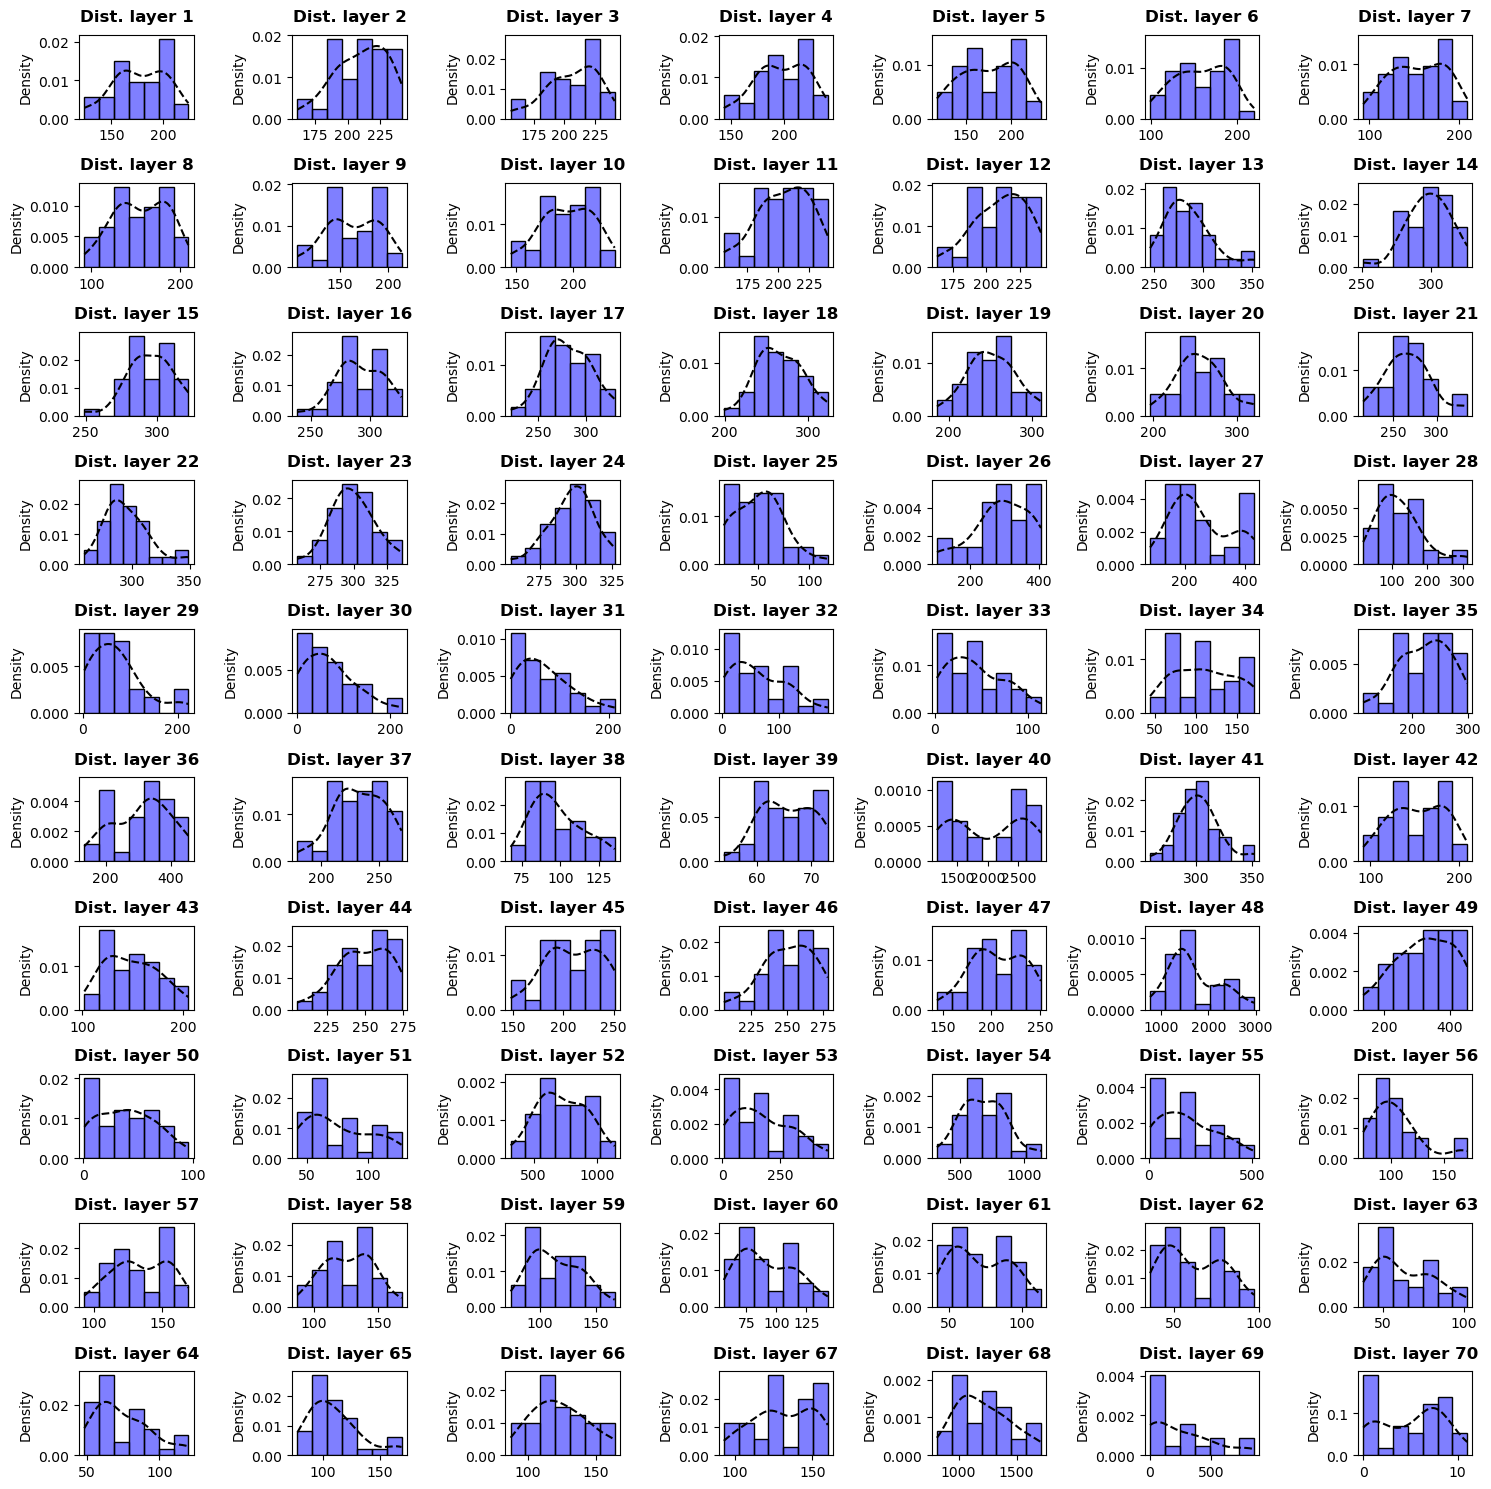

In [148]:
def madaclim_specimens_hists(gdf):
    fig, axes = plt.subplots(10, 7, figsize=(15,15))
    axes = axes.ravel()
    layers = gdf.iloc[:,l1_index:].columns.to_list()
    for i, layer in enumerate(layers):
        sns.histplot(
            data=gdf,
            x=layer,
            color="blue",
            ax=axes[i],
            kde=True, stat="density",
            line_kws={"linestyle" : "--"}
        )
        axes[i].set_xlabel("")
        axes[i].lines[0].set_color("black")
        axes[i].set_title(f"Dist. layer {i+1}", pad=10, weight="bold")
    fig.tight_layout()

madaclim_specimens_hists(gdf_gbs)

In [149]:
def check_normality(gdf):
    layers = gdf.iloc[:,l1_index:].columns.to_list()
    for i, layer in enumerate(layers):
        norm = shapiro(gdf[layer])
        if norm.pvalue < 0.05:
            print(f"layer {i+1} is not normally distributed since pval={norm.pvalue} < 0.05")
        # else:
        #     print(f"{layer} follows a normal distribution (null hypothesis)")
check_normality(gdf_gbs)

layer 13 is not normally distributed since pval=0.01563286781311035 < 0.05
layer 22 is not normally distributed since pval=0.026344725862145424 < 0.05
layer 27 is not normally distributed since pval=0.006803478114306927 < 0.05
layer 28 is not normally distributed since pval=0.011577649042010307 < 0.05
layer 29 is not normally distributed since pval=0.003331586252897978 < 0.05
layer 30 is not normally distributed since pval=0.018307127058506012 < 0.05
layer 31 is not normally distributed since pval=0.028063109144568443 < 0.05
layer 32 is not normally distributed since pval=0.016017835587263107 < 0.05
layer 33 is not normally distributed since pval=0.018792366608977318 < 0.05
layer 34 is not normally distributed since pval=0.04594413936138153 < 0.05
layer 40 is not normally distributed since pval=0.0002975565439555794 < 0.05
layer 48 is not normally distributed since pval=0.007411393336951733 < 0.05
layer 51 is not normally distributed since pval=0.005776598118245602 < 0.05
layer 53 is n

Text(0.5, 1.0, 'Genome size distribution')

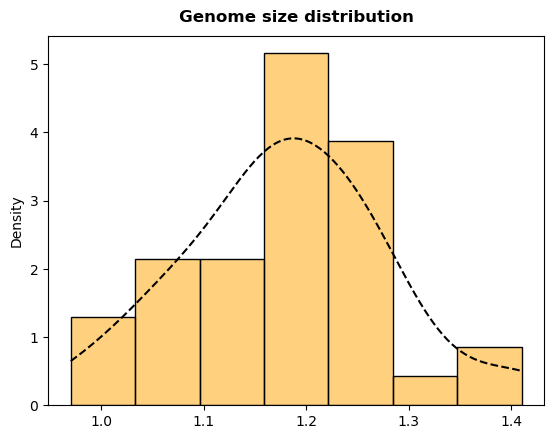

In [150]:
fig, ax = plt.subplots()
sns.histplot(data=gdf_gbs,x="Genome size (2C. pg)",color="orange",ax=ax,kde=True, stat="density",line_kws={"linestyle" : "--"})
ax.set_xlabel("")
ax.lines[0].set_color("black")
ax.set_title(f"Genome size distribution", pad=10, weight="bold")

In [151]:
norm_gs = shapiro(gdf_gbs["Genome size (2C. pg)"])
if norm_gs.pvalue > 0.05:
    print(f"Genome size distribution is normally distributed (pval = {norm_gs.pvalue:.4f})")

Genome size distribution is normally distributed (pval = 0.8546)


**Correlation to GPS position**

In [152]:
def correlation_to_gps(gdf, features):
    pass

In [153]:
# numpy solution to calculate correlation coefficient between 2d (lon/lat) and 1d (clim feature) arrays
print(np.corrcoef(gdf_gbs["Longitude"].values ,gdf_gbs[["Longitude", "Latitude"]].values.T)[0][2])

# Or directly with pandas .corr() method
print(gdf_gbs.corr()["Longitude"]["Latitude"])

0.5957018767885885
0.5957018767885888


/tmp/ipykernel_78223/4008967849.py:5: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(gdf_gbs.corr()["Longitude"]["Latitude"])


In [154]:
# Correlation with Latitude
gdf_gbs.corr()[abs(gdf_gbs.corr()["Latitude"])>0.5]["Latitude"]

/tmp/ipykernel_78223/1189864861.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gdf_gbs.corr()[abs(gdf_gbs.corr()["Latitude"])>0.5]["Latitude"]


Genome size (2C. pg)                                                    -0.553080
Longitude                                                                0.595702
Latitude                                                                 1.000000
layer1 : Monthly minimum temperature (C x 10)_January                    0.589604
layer3 : Monthly minimum temperature (C x 10)_March                      0.504263
layer4 : Monthly minimum temperature (C x 10)_April                      0.658330
layer5 : Monthly minimum temperature (C x 10)_May                        0.769960
layer6 : Monthly minimum temperature (C x 10)_June                       0.758555
layer7 : Monthly minimum temperature (C x 10)_July                       0.760966
layer8 : Monthly minimum temperature (C x 10)_August                     0.745333
layer9 : Monthly minimum temperature (C x 10)_September                  0.671613
layer10 : Monthly minimum temperature (C x 10)_October                   0.540008
layer18 : Monthl

In [155]:
# Correlation with Longitude
gdf_gbs.corr()[abs(gdf_gbs.corr()["Longitude"])>0.5]["Longitude"]

/tmp/ipykernel_78223/4079369275.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gdf_gbs.corr()[abs(gdf_gbs.corr()["Longitude"])>0.5]["Longitude"]


Longitude                                                 1.000000
Latitude                                                  0.595702
layer38 : bio2_Mean Diurnal Range(Mean(period max-min)   -0.538404
layer43 : bio7_Temperature Annual Range (5-6)            -0.613925
Name: Longitude, dtype: float64

We could use the most correlated features to impute missing Lat/Long : 
- **Lat** -> layer40 : bio4_Temperature Seasonality (C of V) with r2 = -0.9
- **Lon** -> layer43 : bio7_Temperature Annual Range (5-6) with r2 = -0.613925

In [156]:
# Correlation with genome size
gdf_gbs.corr()[abs(gdf_gbs.corr()["Genome size (2C. pg)"])>0.5]["Genome size (2C. pg)"]

/tmp/ipykernel_78223/2233172131.py:2: FutureWarning: The default value of numeric_only in GeoDataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  gdf_gbs.corr()[abs(gdf_gbs.corr()["Genome size (2C. pg)"])>0.5]["Genome size (2C. pg)"]


Genome size (2C. pg)                               1.00000
Latitude                                          -0.55308
layer40 : bio4_Temperature Seasonality (C of V)    0.53222
Name: Genome size (2C. pg), dtype: float64

Text(0.5, 0.98, 'Correlation map for all 70 madaclim layers')

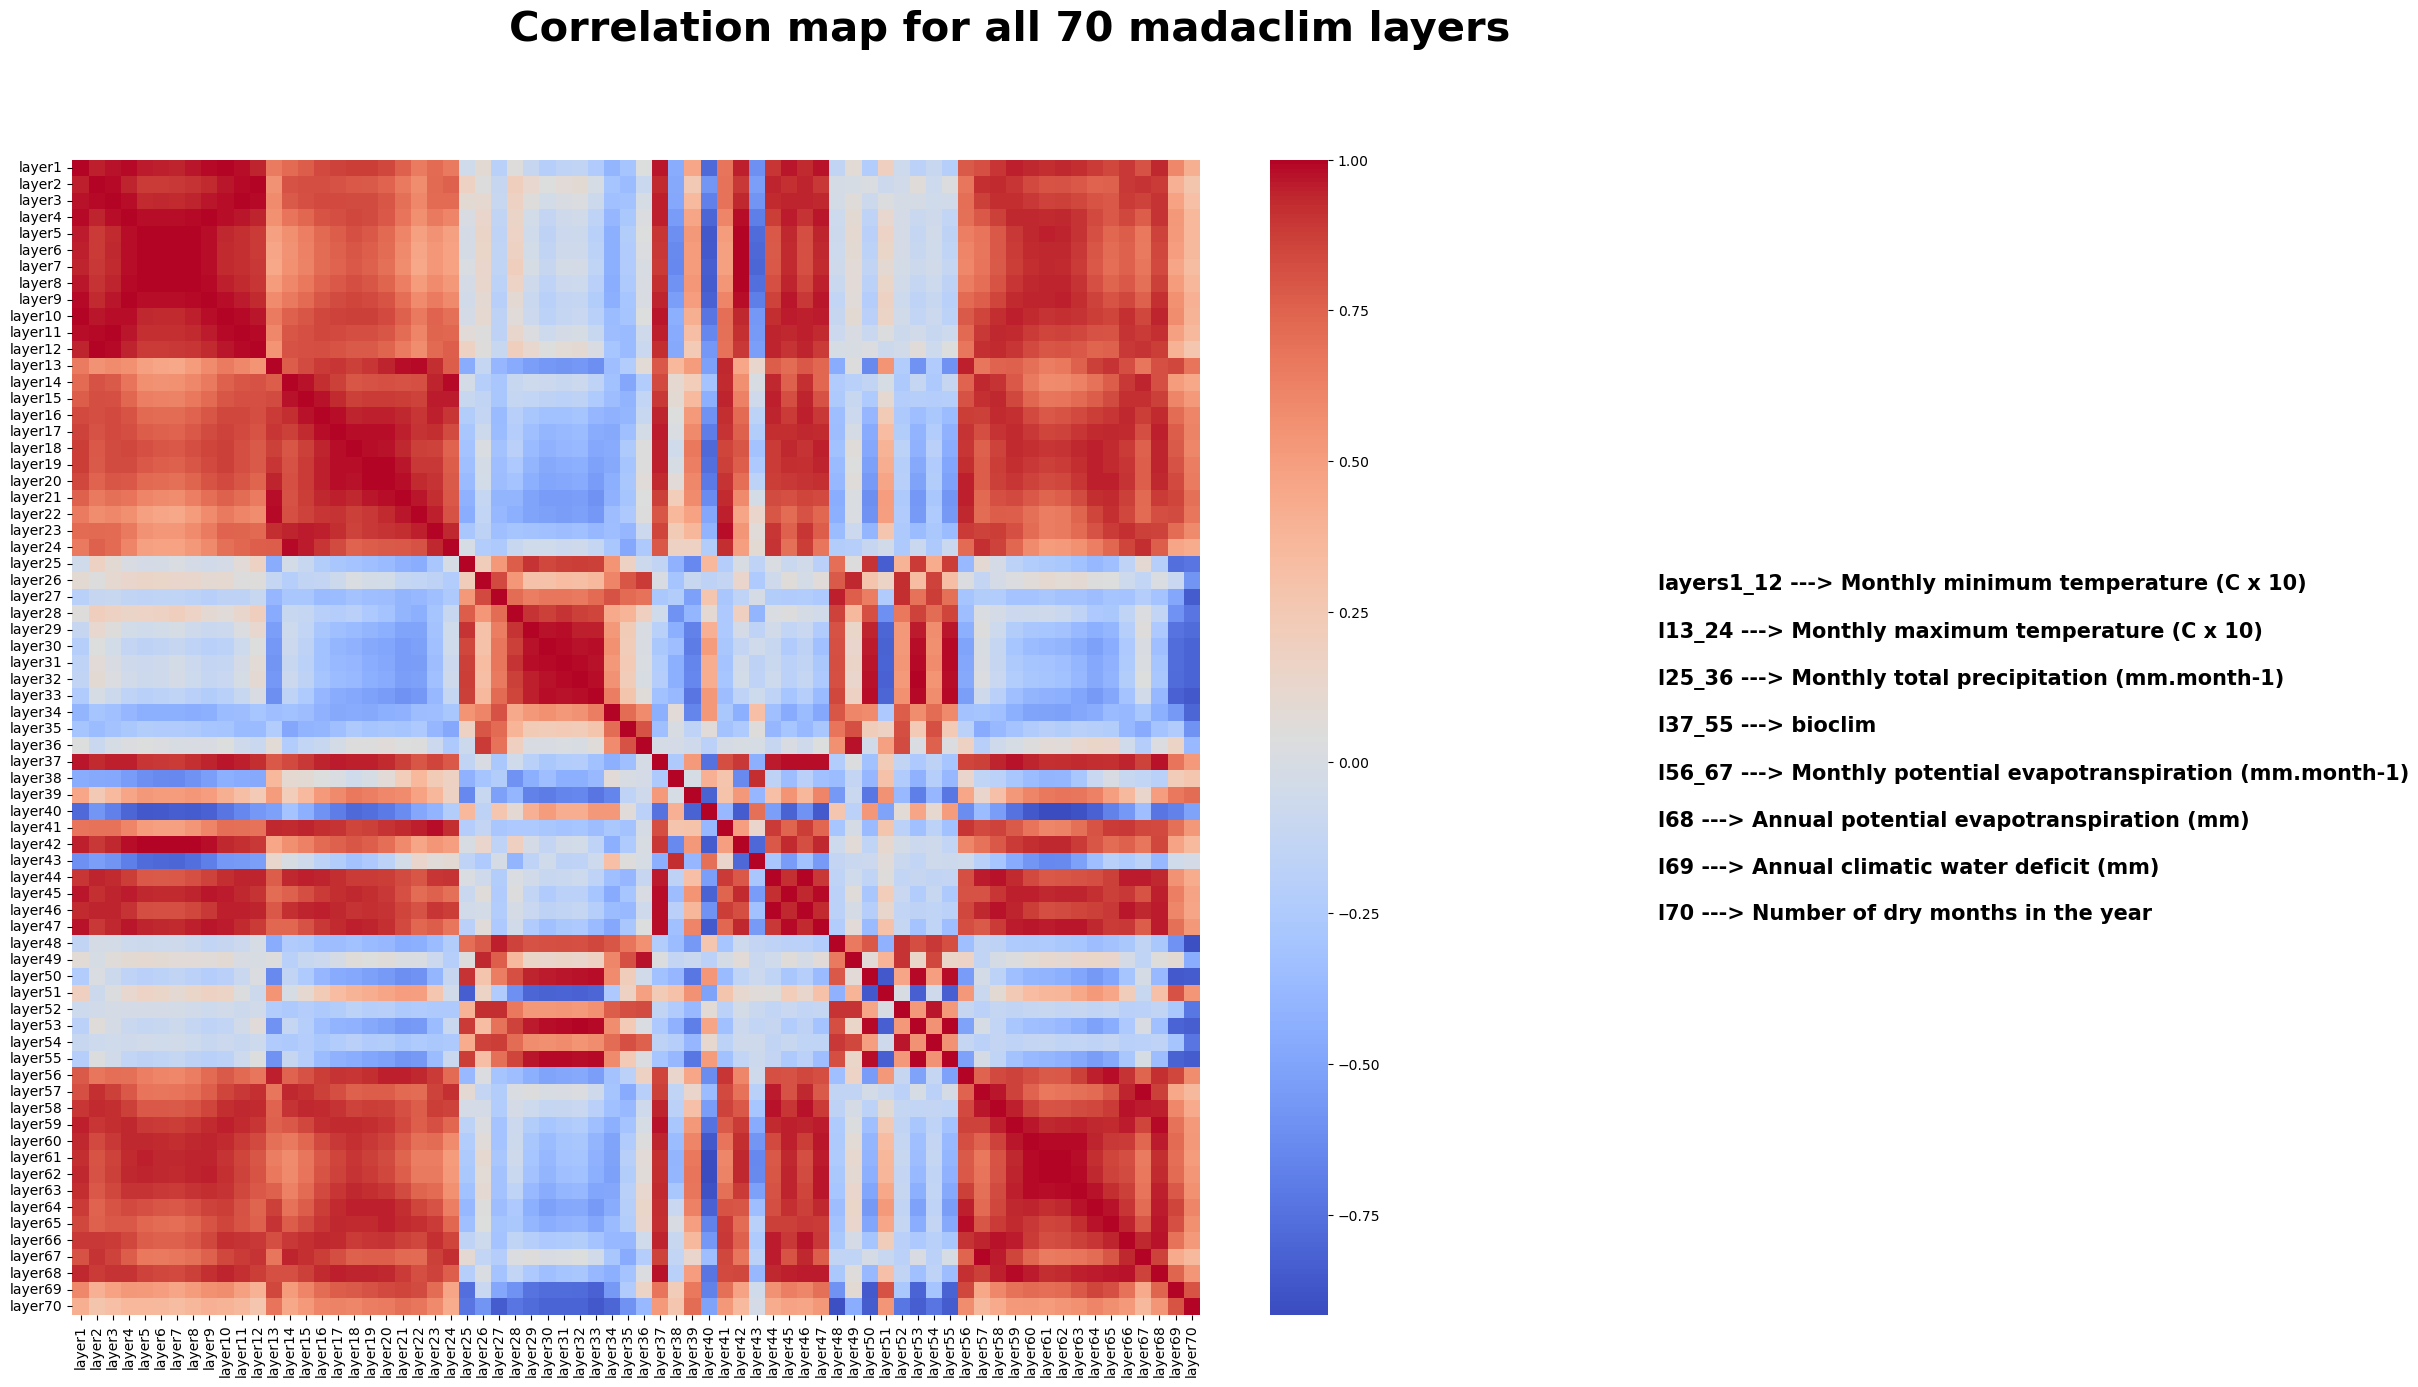

In [157]:
# All pairs
layers_def = """

layers1_12 ---> Monthly minimum temperature (C x 10)

l13_24 ---> Monthly maximum temperature (C x 10)

l25_36 ---> Monthly total precipitation (mm.month-1)

l37_55 ---> bioclim

l56_67 ---> Monthly potential evapotranspiration (mm.month-1)

l68 ---> Annual potential evapotranspiration (mm)

l69 ---> Annual climatic water deficit (mm)

l70 ---> Number of dry months in the year
"""
fig, axes = plt.subplots(1, 2, figsize=(25,15), gridspec_kw={'width_ratios': [4, 1]})

sns.heatmap(
    gdf_gbs.iloc[:,l1_index:].corr(), 
    xticklabels=[l for l in mada_layers], 
    yticklabels=[l for l in mada_layers], 
    cmap="coolwarm", ax=axes[0],
    )
axes[1].text(0, 0.5, layers_def, va="center", ha="left", color="black", size=15, weight="bold")
axes[1].axis("off")
fig.suptitle("Correlation map for all 70 madaclim layers", weight="bold", size=30)

Obviously we see some expected patterns of strong positive and negative correlations:

Examples : 

***Pos***
- Min/Max temperatures (between themselves) and other layers such as l37(max annual temp), l41(max warmest), l42(min coldest), l44-47 (mean temps of wet/dry war/cold quarters), l56-58(monthly+annual evapotranspiration)


***Neg***
- l69(Annual water deficit), l70(num dry months) with l25-36(monthly precipitations) and some bioclim precipitation layers(i.e. l47)

---

## Unsupervised clustering with madaclim layers

In [158]:
gdf_gbs.head()

,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
Species code,,,,,,,,,,,,,,,,,,,,,
ABA,1.25,46.862400,-24.754100,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ...",155.0,195.0,188.0,171.0,136.0,...,50.0,44.0,47.0,60.0,92.0,110.0,123.0,1022.0,77.0,4.0
AMB,1.27,48.943300,-18.452200,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ...",157.0,203.0,199.0,185.0,164.0,...,61.0,47.0,48.0,56.0,92.0,109.0,121.0,1041.0,16.0,1.0
AMBON,1.16,46.419806,-15.574583,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ...",222.0,236.0,238.0,235.0,217.0,...,107.0,93.0,102.0,120.0,164.0,164.0,156.0,1709.0,849.0,8.0
ANK1,1.17,49.543300,-12.949100,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ...",206.0,228.0,227.0,224.0,211.0,...,99.0,83.0,85.0,96.0,137.0,147.0,146.0,1482.0,501.0,8.0
ARE,1.11,48.200000,-18.933300,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ...",130.0,176.0,166.0,153.0,126.0,...,48.0,40.0,41.0,50.0,84.0,95.0,102.0,891.0,61.0,4.0


## Climate-based clustering

As shown above, there was correlation between some of the climate variables and the geographical location of the samples, especially for Latitude. Using an unsupervised approach, let's see what our clusters will look like on the map based on the madaclim layers AND/OR GPS positions as features.

### Climate data standardization

No categorial data so no need to convert before scaling

In [159]:
# Separating by layers
features = [f"{k} : {v}" for k,v in mada_layers.items()]
X = gdf_gbs[features]
X.head()

,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,layer6 : Monthly minimum temperature (C x 10)_June,layer7 : Monthly minimum temperature (C x 10)_July,layer8 : Monthly minimum temperature (C x 10)_August,layer9 : Monthly minimum temperature (C x 10)_September,layer10 : Monthly minimum temperature (C x 10)_October,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
Species code,,,,,,,,,,,,,,,,,,,,,
ABA,155.0,195.0,188.0,171.0,136.0,122.0,120.0,124.0,138.0,173.0,...,50.0,44.0,47.0,60.0,92.0,110.0,123.0,1022.0,77.0,4.0
AMB,157.0,203.0,199.0,185.0,164.0,149.0,142.0,139.0,144.0,179.0,...,61.0,47.0,48.0,56.0,92.0,109.0,121.0,1041.0,16.0,1.0
AMBON,222.0,236.0,238.0,235.0,217.0,199.0,191.0,193.0,205.0,237.0,...,107.0,93.0,102.0,120.0,164.0,164.0,156.0,1709.0,849.0,8.0
ANK1,206.0,228.0,227.0,224.0,211.0,192.0,186.0,188.0,194.0,221.0,...,99.0,83.0,85.0,96.0,137.0,147.0,146.0,1482.0,501.0,8.0
ARE,130.0,176.0,166.0,153.0,126.0,107.0,109.0,107.0,114.0,152.0,...,48.0,40.0,41.0,50.0,84.0,95.0,102.0,891.0,61.0,4.0


In [160]:
# Scaling data
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pd.DataFrame(X_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.890067,-0.785269,-0.897862,-1.074336,-1.287619,-1.176651,-1.126965,-1.068908,-0.915779,-0.935557,...,-1.119959,-1.027260,-0.966605,-0.760608,-0.811644,-0.667160,-0.411554,-0.839854,-0.695047,-0.346835
1,-0.811750,-0.373872,-0.363608,-0.498838,-0.375188,-0.298776,-0.398332,-0.557931,-0.698575,-0.678192,...,-0.556519,-0.850476,-0.908640,-0.972604,-0.811644,-0.716236,-0.516211,-0.756344,-0.936351,-1.263471
2,1.733567,1.323144,1.530566,1.556509,1.351911,1.326918,1.224534,1.281584,1.509666,1.809671,...,1.799688,1.860217,2.221468,2.419334,2.382182,1.982912,1.315276,2.179700,2.358839,0.875346
3,1.107028,0.911746,0.996312,1.104333,1.156391,1.099321,1.058935,1.111259,1.111459,1.123364,...,1.389913,1.270936,1.236064,1.147357,1.184497,1.148630,0.791994,1.181972,0.982217,0.875346
4,-1.869035,-1.762339,-1.966370,-1.814261,-1.613486,-1.664359,-1.491282,-1.648014,-1.784596,-1.836334,...,-1.222403,-1.262973,-1.314395,-1.290598,-1.166514,-1.403292,-1.510447,-1.415635,-0.758340,-0.346835


In [161]:
X_scaled.mean(axis=0)

array([-4.26835744e-16,  5.52673523e-16,  1.08678082e-16,  2.14543098e-16,
       -3.60072332e-17, -1.47029536e-16, -1.51530440e-16, -2.61052441e-16,
        2.40048222e-16,  1.70284207e-16,  3.20689421e-16, -9.45189872e-17,
       -2.58051838e-16, -1.20174141e-15,  7.09642555e-16,  2.88057866e-16,
       -9.57192283e-16,  1.65033152e-16, -6.60132609e-17, -2.10042194e-16,
        6.81136829e-16, -8.76176009e-16,  1.52130560e-15,  1.72609674e-15,
        1.20024111e-16, -3.06061482e-16,  1.26025316e-16,  4.05081374e-17,
       -4.80096443e-17,  2.70054249e-17, -3.00060277e-18,  2.40048222e-17,
       -5.40108498e-17, -1.08021700e-16,  2.52800783e-16, -1.89037974e-16,
        3.64573236e-16, -1.14022905e-16,  5.04101265e-16,  7.50150692e-17,
       -1.39077938e-15,  3.81076552e-16, -3.31566606e-16, -8.17664255e-16,
        2.46049427e-16, -5.45359553e-16,  4.92098854e-16,  2.04040988e-16,
       -2.82056660e-16,  1.44028933e-16,  2.07041591e-16, -1.62032550e-16,
        6.00120554e-17,  

### PCA for madaclim layers 1-70

1 component(s) = 58.55% of explained variance (cumul = 58.55%)
2 component(s) = 20.89% of explained variance (cumul = 79.44%)
3 component(s) = 9.39% of explained variance (cumul = 88.82%)
4 component(s) = 7.57% of explained variance (cumul = 96.39%)
5 component(s) = 1.10% of explained variance (cumul = 97.49%)
6 component(s) = 0.62% of explained variance (cumul = 98.11%)
7 component(s) = 0.54% of explained variance (cumul = 98.66%)
8 component(s) = 0.37% of explained variance (cumul = 99.03%)
9 component(s) = 0.22% of explained variance (cumul = 99.25%)
10 component(s) = 0.16% of explained variance (cumul = 99.42%)
11 component(s) = 0.13% of explained variance (cumul = 99.55%)
12 component(s) = 0.12% of explained variance (cumul = 99.66%)
13 component(s) = 0.08% of explained variance (cumul = 99.74%)
14 component(s) = 0.07% of explained variance (cumul = 99.81%)
15 component(s) = 0.04% of explained variance (cumul = 99.85%)
16 component(s) = 0.04% of explained variance (cumul = 99.89%)

PCA()

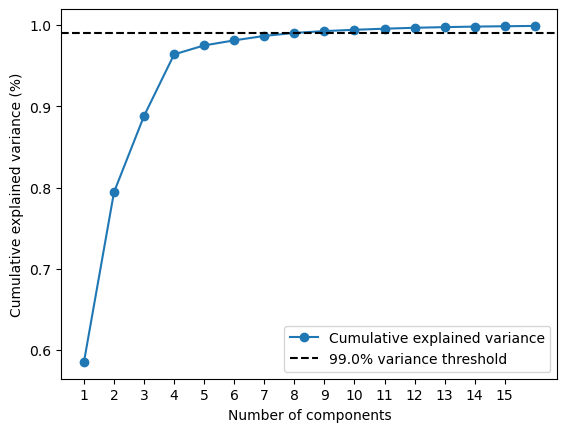

In [162]:
def find_pca_ncompo(X, threshold):
    # Calculate cumulated variance
    pca = PCA()
    pca.fit(X)
    
    # Sum of explained variances for n_compo
    total = 0
    for i, compo in enumerate(pca.components_):
        total += pca.explained_variance_ratio_[i]
        print(
            f"{i+1} component(s) =",
            f"{pca.explained_variance_ratio_[i]*100:.2f}% of explained variance",
            f"(cumul = {total*100:.2f}%)"
        )
        if total*100 >= 99.9:
            max_compo = i
            break
    
    # Plot
    n_compo = np.arange(1, max_compo+1)
    cumul = pca.explained_variance_ratio_.cumsum()
    plt.figure()
    plt.plot(n_compo, cumul[:max_compo], marker="o")
    plt.xticks(np.arange(min(n_compo), max(n_compo)))
    plt.axhline(y=threshold, color="black", linestyle="--" )
    plt.legend(["Cumulative explained variance", f"{threshold*100}% variance threshold"])
    plt.ylabel("Cumulative explained variance (%)")
    plt.xlabel("Number of components")
    return pca
find_pca_ncompo(X_scaled, 0.99)

In [163]:
# Dimensionality reduction with 8 components to capture 99% of the variance
pca = PCA(n_components=8)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

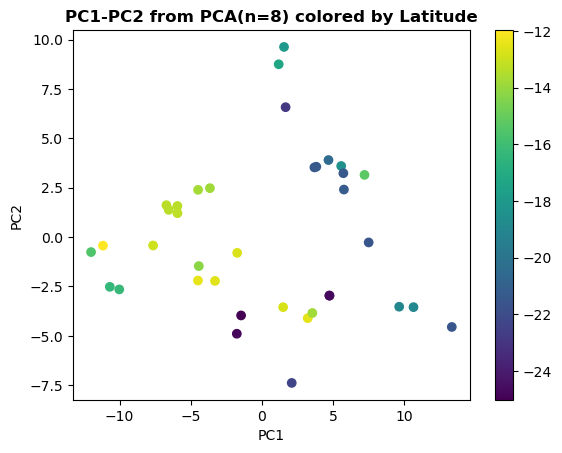

In [164]:
# Plot the first 2 dimension for visualization purposes
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gdf_gbs["Latitude"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1-PC2 from PCA(n=8) colored by Latitude", weight="bold")
plt.colorbar()

Text(0.5, 1.0, 't-SNE projection from PCA(n=8) colored by Latitude')

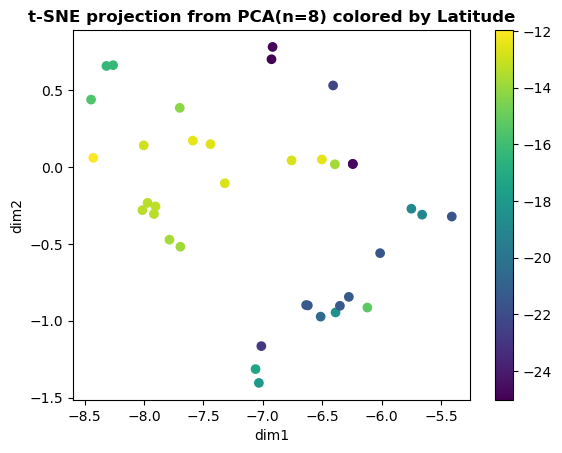

In [165]:
# t-SNE viz with 2 compo
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X_pca)

plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gdf_gbs["Latitude"])
plt.xlabel("dim1")
plt.ylabel("dim2")
plt.colorbar()
plt.title("t-SNE projection from PCA(n=8) colored by Latitude", weight="bold")

### Clustering

#### K-means
Using the 8PC-reduced data, let's determine the number of K clusters

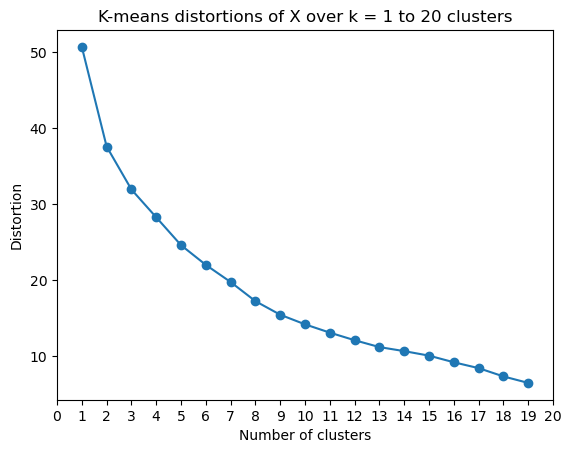

[50.644570790717864,
 37.54383967105194,
 31.89123736997579,
 28.23351215462066,
 24.567994664436302,
 21.975277391717874,
 19.720563633231478,
 17.203226576961047,
 15.417544458933591,
 14.154406587907213,
 13.063774953177159,
 12.065734638080114,
 11.162486939497317,
 10.631107088662807,
 10.037392579538887,
 9.164953078130873,
 8.394702844450633,
 7.304844074646544,
 6.449542508482596]

In [166]:
# Elbow method
def elbow_method(X, min_clusters, max_clusters):
    # Kmeans for each min/max clusters
    distortions = []
    for i in range(min_clusters, max_clusters):
        km = KMeans(n_clusters=i, n_init=10).fit(X)
        distortions.append(np.sqrt(km.inertia_))
    # Plot distortions
    fig = plt.figure()
    
    plt.plot(range(min_clusters,len(distortions)+min_clusters), distortions, marker="o")
    plt.title(
        f"K-means distortions of {list(locals().keys())[0]} over k = {min_clusters} to {max_clusters} clusters"
    )
    plt.xlabel("Number of clusters")
    plt.xticks(range(min_clusters-1, max_clusters+1))
    plt.ylabel("Distortion")
    plt.show()
    
    return distortions

elbow_method(X_pca, 1, 20)

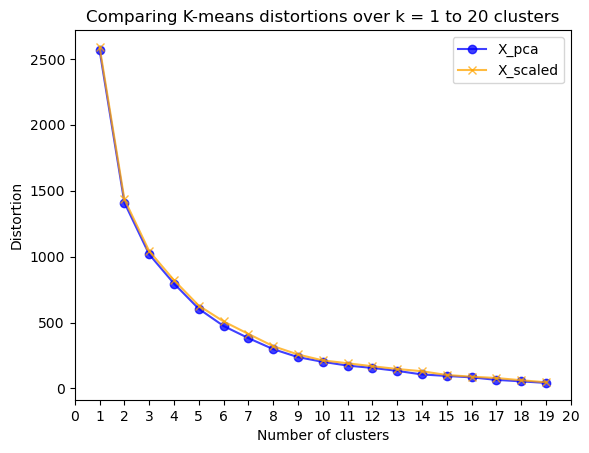

In [167]:
# Comparing non-PCA vs 8PC
distos_pca = []
distos_scaled = []
min_clusters = 1
max_clusters = 20

for i in range(min_clusters, max_clusters):
    km_pca = KMeans(n_clusters=i, n_init=10).fit(X_pca)
    km_scaled = KMeans(n_clusters=i, n_init=10).fit(X_scaled)
    distos_pca.append(km_pca.inertia_)
    distos_scaled.append(km_scaled.inertia_)
# Plot distos_pca
fig = plt.figure()

plt.plot(range(min_clusters,len(distos_pca)+min_clusters), distos_pca, marker="o", c="blue", alpha=0.75)
plt.plot(range(min_clusters,len(distos_scaled)+min_clusters), distos_scaled, marker="x", c="orange", alpha=0.75)
plt.title(f"Comparing K-means distortions over k = {min_clusters} to {max_clusters} clusters")
plt.xlabel("Number of clusters")
plt.xticks(range(min_clusters-1, max_clusters+1))
plt.ylabel("Distortion")
plt.legend(["X_pca", "X_scaled"])
plt.show()

Not very clear, let's use the Silhouette score

For k = 2, silouhette avg = 0.3866288692181401
For k = 3, silouhette avg = 0.38019905183804126
For k = 4, silouhette avg = 0.34820543548157334
For k = 5, silouhette avg = 0.3966376486115509
For k = 6, silouhette avg = 0.43380921124946137
For k = 7, silouhette avg = 0.44694777088956134
For k = 8, silouhette avg = 0.4613861281822642
For k = 9, silouhette avg = 0.4803882129669264
For k = 10, silouhette avg = 0.47369764681194976
For k = 11, silouhette avg = 0.5022657047285667
For k = 12, silouhette avg = 0.48191179023293335
For k = 13, silouhette avg = 0.4861448808124455
For k = 14, silouhette avg = 0.46904024756612506
For k = 15, silouhette avg = 0.4565585349642577


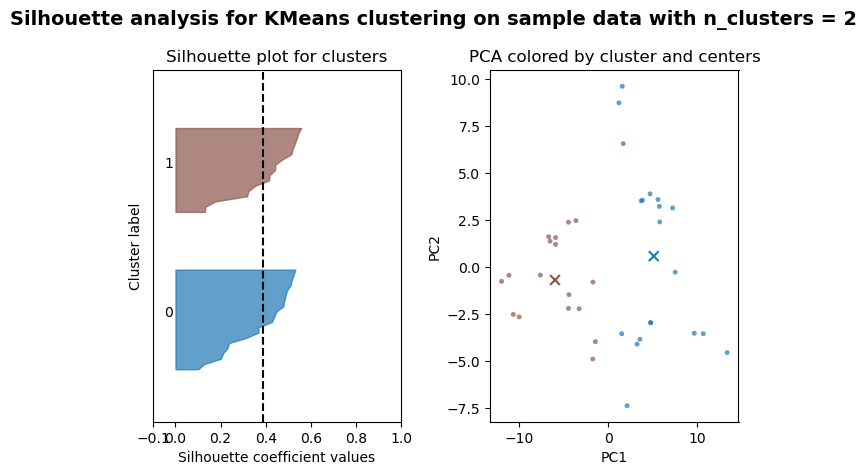

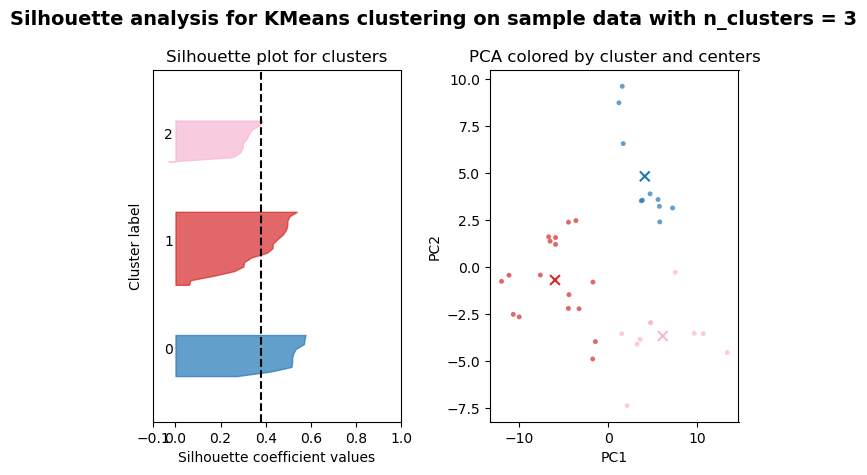

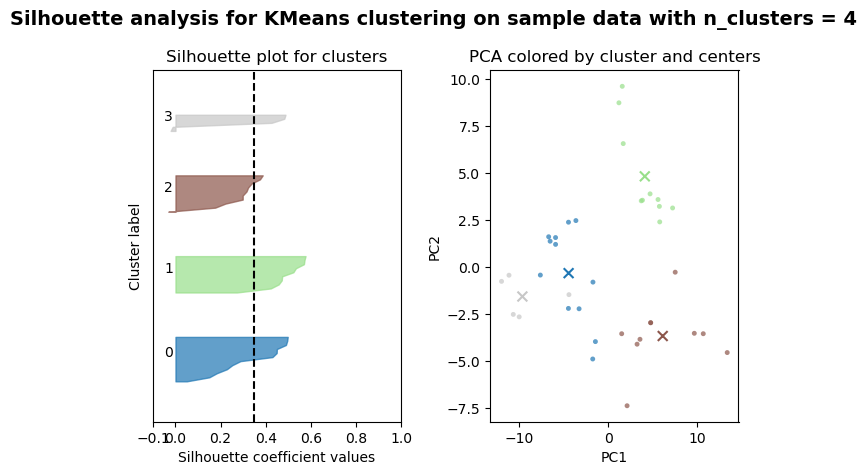

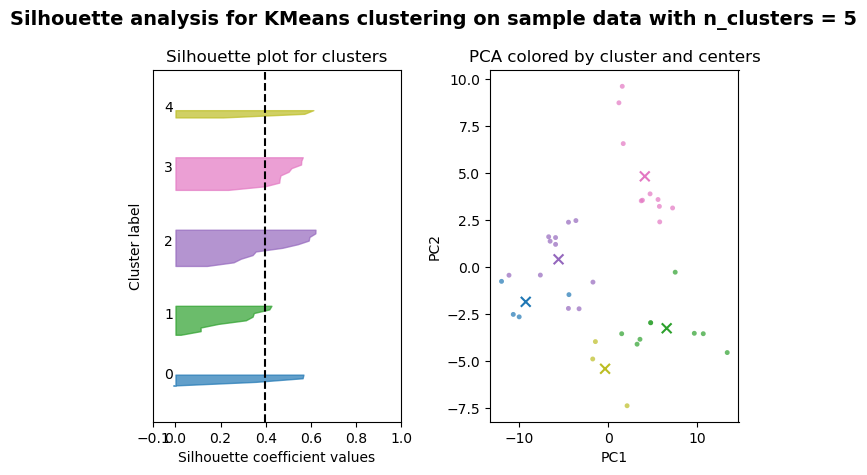

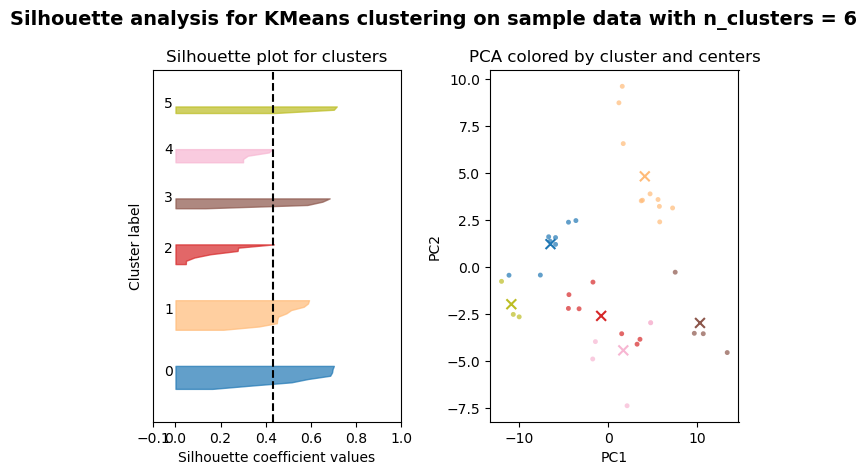

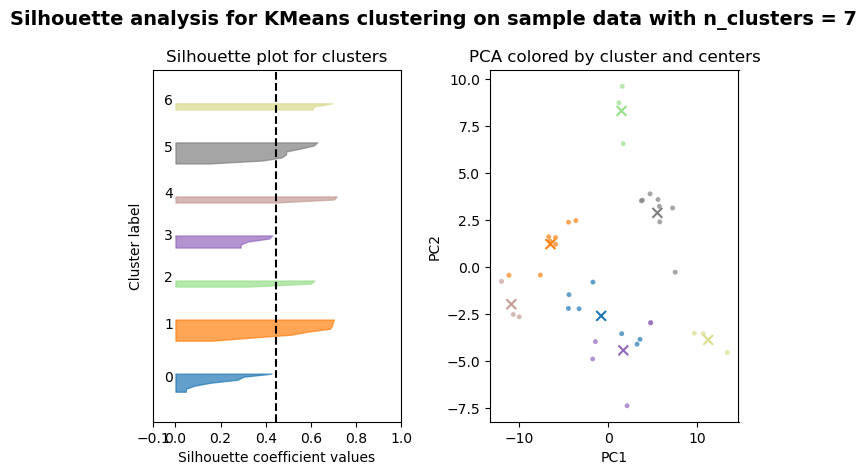

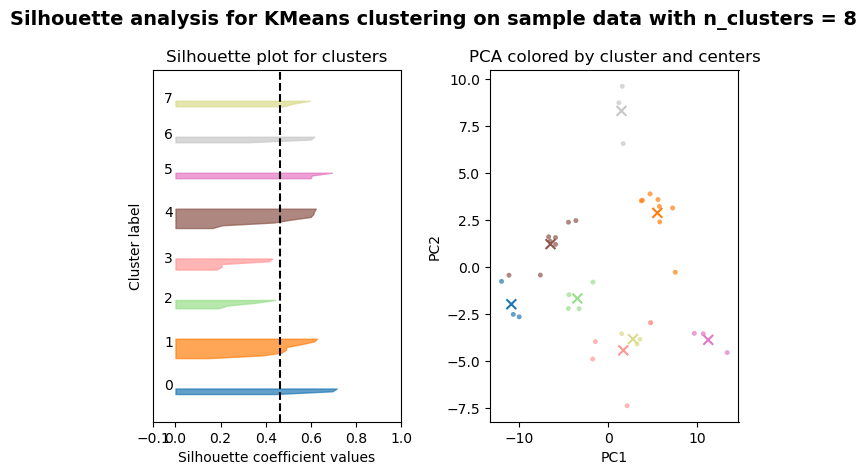

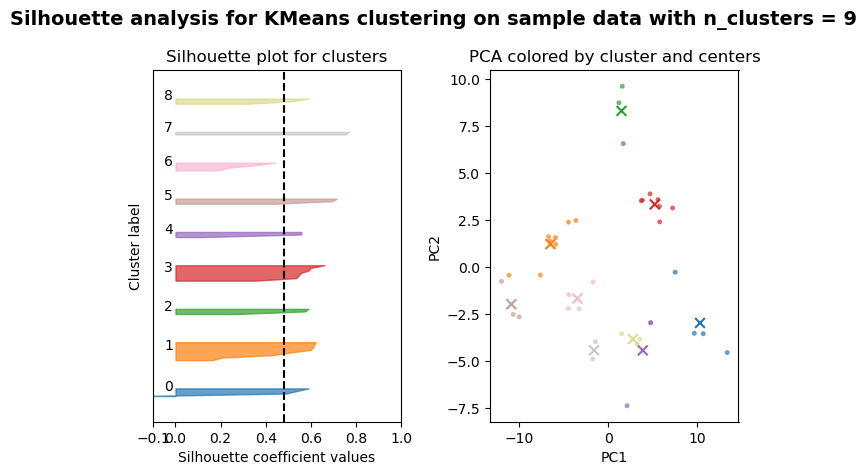

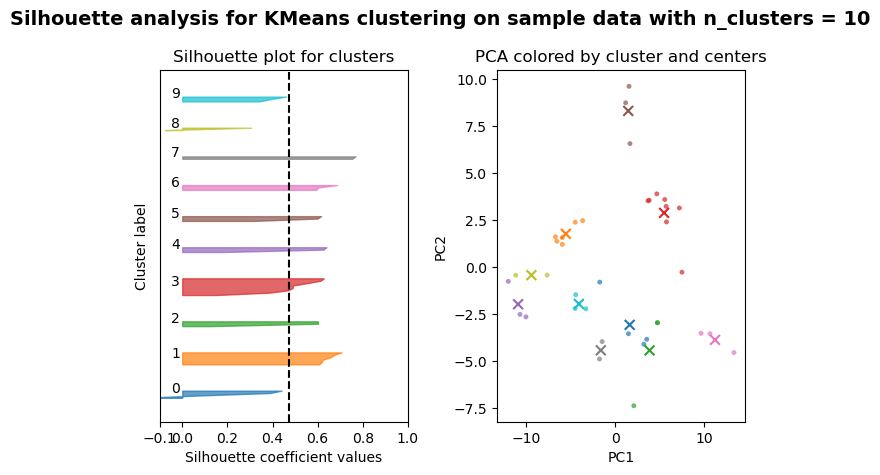

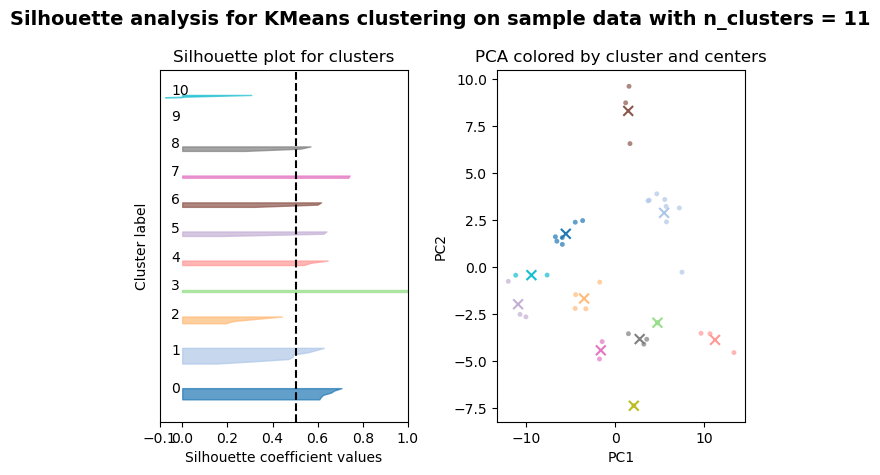

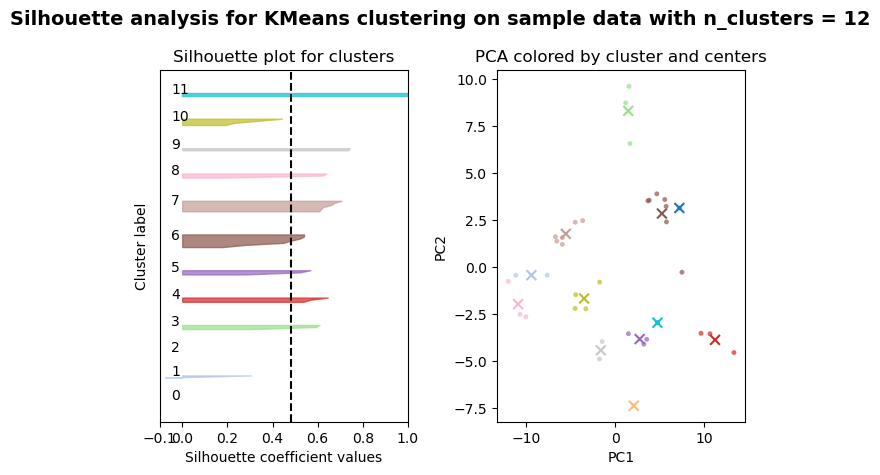

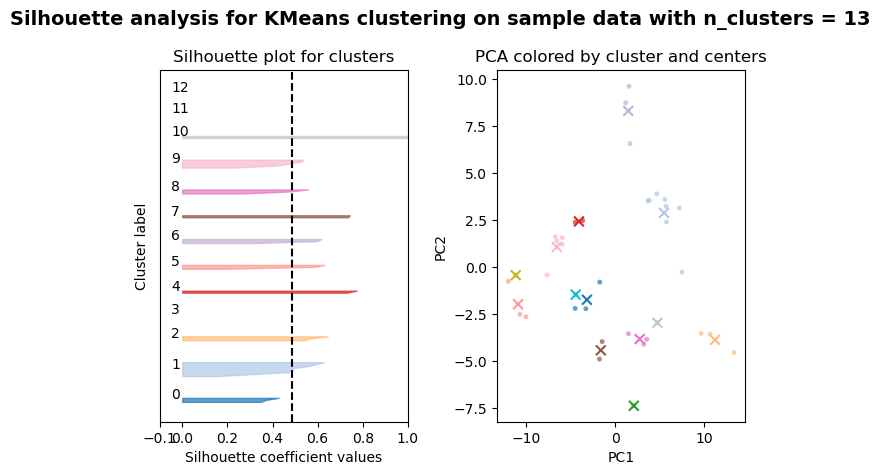

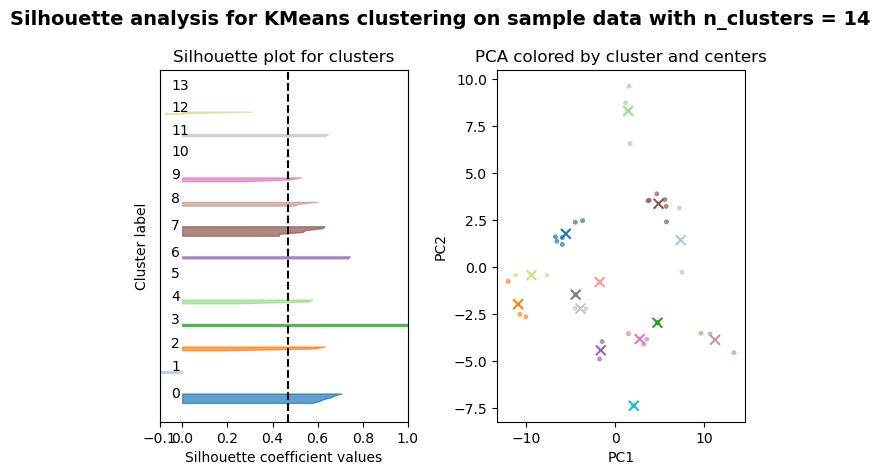

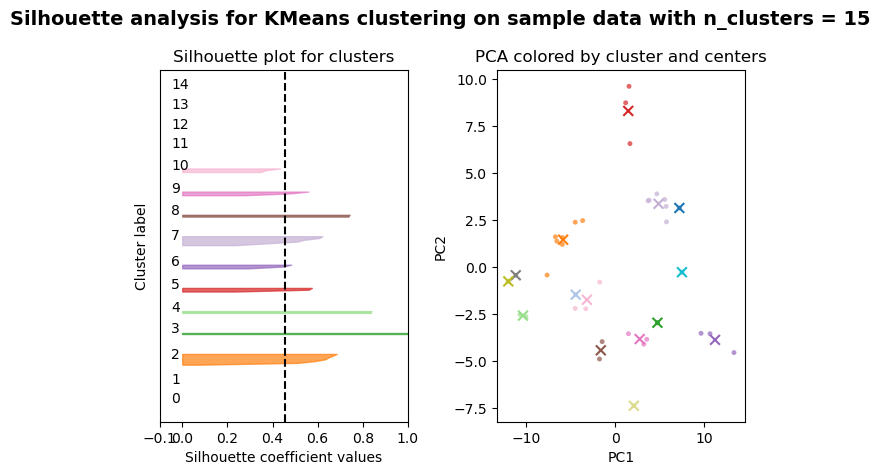

In [168]:
# Inspired by sklearn docs
def silouhette_plot(X, min_clusters, max_clusters):
    range_n_clusters = list(range(min_clusters, max_clusters+1))
    # label_colors = [plt.cm.tab20(i) for i in range_n_clusters]
    
    for n_clusters in range_n_clusters:
        # Set fig params
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        # KMeans + silouhette avg
        km = KMeans(n_clusters=n_clusters, n_init=10).fit(X)
        silhouette_avg = silhouette_score(X, km.labels_)
        print(f"For k = {n_clusters}, silouhette avg = {silhouette_avg}")
        
        # Silouhette scores for each samples
        sample_silouhette_vals = silhouette_samples(X, km.labels_)
        y_lower = 10
        
        for i in range(n_clusters):
            # Sort sil scores per sample
            ith_cluster_silhouette_values = sample_silouhette_vals[km.labels_ == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            label_color = plt.cm.tab20(i / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=label_color,
                edgecolor=label_color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot for clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot PCA
        pca = PCA(n_components=2).fit(X)
        data2d = pca.transform(X)
        cluster_colors = plt.cm.tab20(km.labels_.astype(float) / n_clusters)
        ax2.scatter(
            data2d[:,0], data2d[:,1], marker=".", s=50, lw=0, c=cluster_colors, alpha=0.7, edgecolor="k"
        )
        
        # Labeling the clusters
        centers2d = pca.transform(km.cluster_centers_)
        centers_colors = plt.cm.tab20(np.unique(km.labels_.astype(float) / n_clusters))
        ax2.scatter(centers2d[:, 0], centers2d[:, 1], marker="x", c=centers_colors, s=50)

        ax2.set_title("PCA colored by cluster and centers")
        ax2.set_xlabel("PC1")
        ax2.set_ylabel("PC2")

        plt.suptitle(
            f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
            fontsize=14,
            fontweight="bold",
        )
        fig.tight_layout()

    plt.show()
    
silouhette_plot(X_scaled, 2, 15)

With 8PCs-reduced data

For k = 2, silouhette avg = 0.391926362480854
For k = 3, silouhette avg = 0.39235620066652926
For k = 4, silouhette avg = 0.35688544469053024
For k = 5, silouhette avg = 0.4070884167612492
For k = 6, silouhette avg = 0.43812710005580446
For k = 7, silouhette avg = 0.44758239647762177
For k = 8, silouhette avg = 0.4668555767115038
For k = 9, silouhette avg = 0.5099277329796472
For k = 10, silouhette avg = 0.5205113139477354


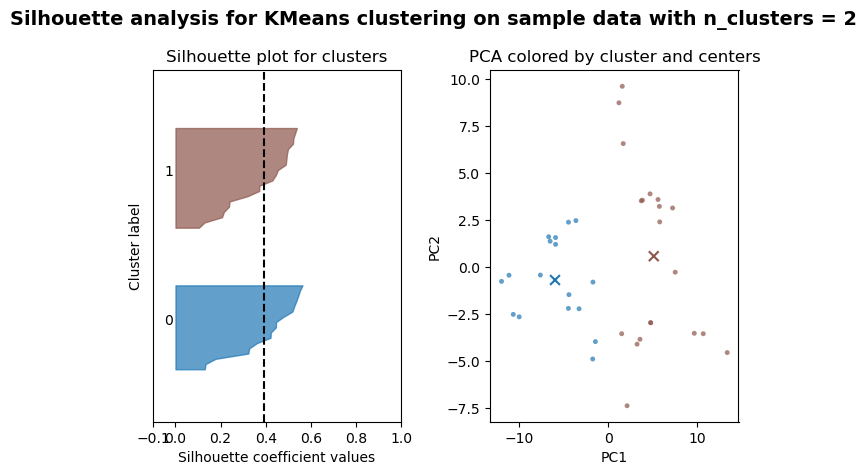

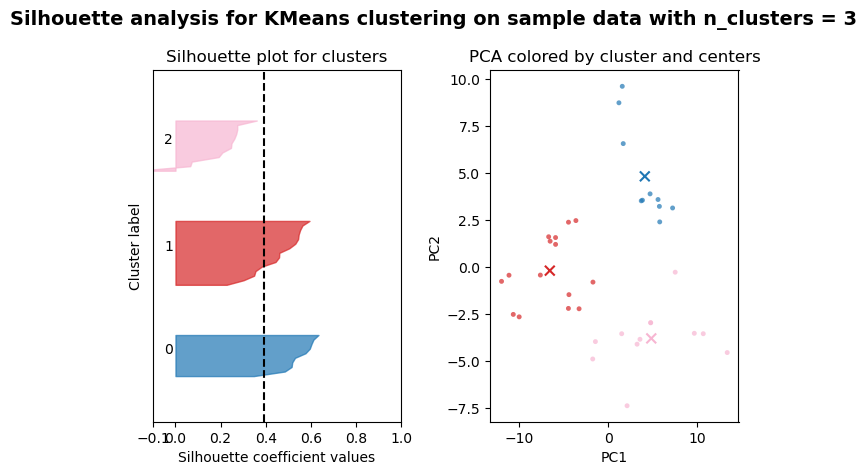

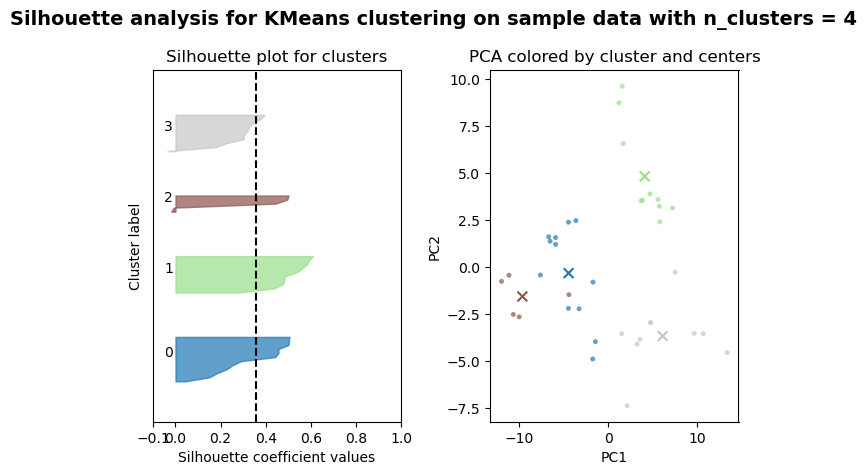

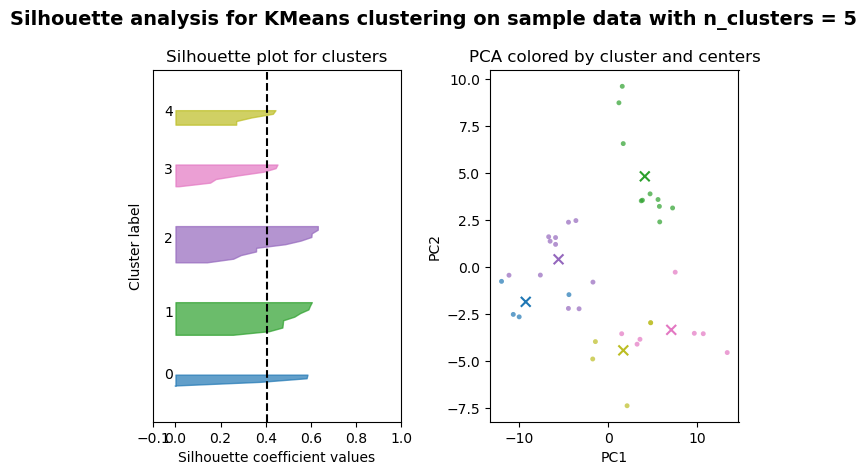

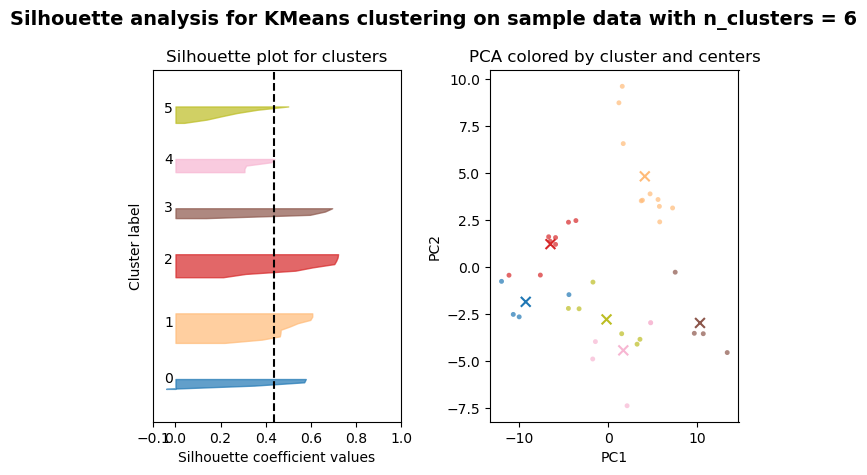

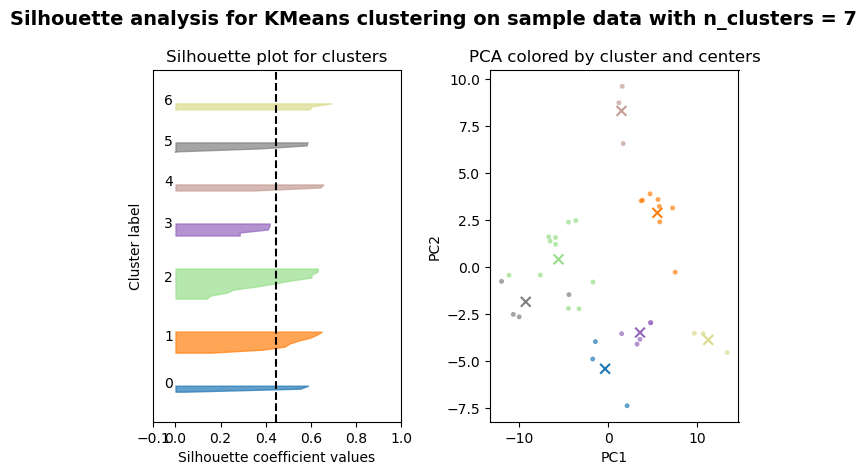

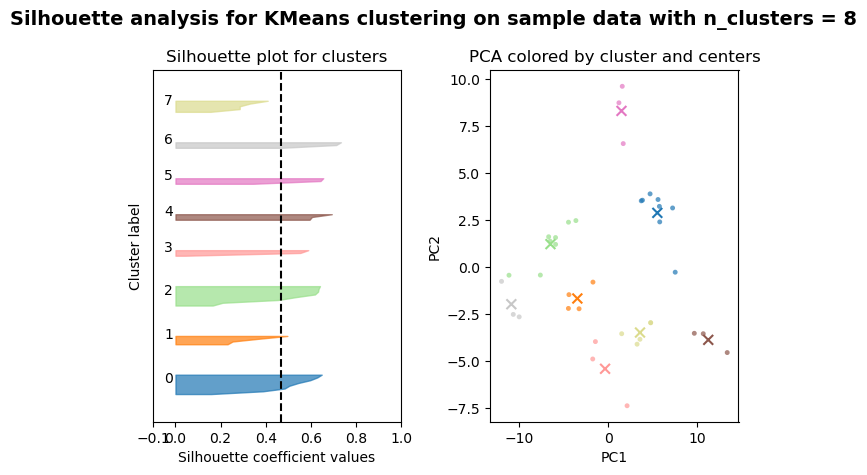

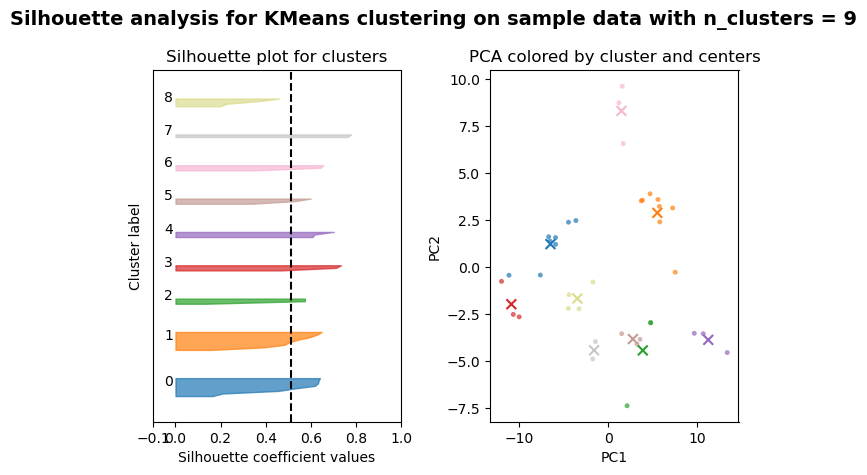

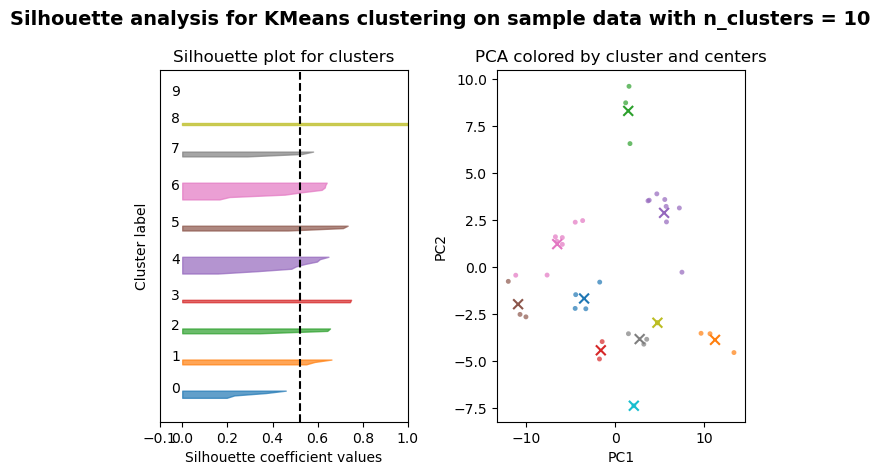

In [169]:
silouhette_plot(X_pca, 2, 10)

Picking 5 to 8 clusters based on Silhouette score and PCA cluster overlap with 8PCs-reduced data

In [170]:
# Fitting the model for 5 to 8 PCs
km_pca = KMeans(n_clusters=5, n_init=10).fit(X_pca)


In [171]:
gdf_gbs["cluster"] = km_pca.labels_

In [229]:
list(set(km_pca.labels_))

[0, 1, 2, 3, 4]

In [248]:
# Wrap the kmeans clustering + map plotting together
def kmeans_map_plot(X, min_k, max_k, layer_num, gdf):
    if min_k > max_k:
        raise ValueError("min_k must be smaller than max_k")
    if min_k == 0:
        raise ValueError("Provide a K greater than 0")
    
    # Setup subplots with 2 cols always
    if min_k % 2 != 0 and max_k % 2 != 0:
        nrows = int((max_k - min_k) / 2 + 1)
    elif min_k % 2 == 0 and max_k % 2 == 0:
        nrows = int((max_k - min_k) / 2 + 1)
    else : 
        nrows = int((max_k - min_k + 1) / 2)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(5*nrows, 15))
    axes = axes.ravel()
    layer = mada_layers[f"layer{layer_num}"]
    
    # Open raster and fit kmeans for each k
    with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_mada:
        for i, k in enumerate(range(min_k, max_k+1)):
            # Fit the model and get clusters
            km = KMeans(n_clusters=k, n_init=10).fit(X)
                            
            axes[i] = rasterio.plot.show(
                    raster_mada.read(layer_num, masked=True),
                    transform=raster_mada.transform,
                    alpha=0.5,
                    cmap="Greys", 
                    ax=axes[i], 
                    title=f"layer{layer_num} : {layer} \nand K-Means with k={k} clusters",
                )
            # cax = plt.axes([0.85, 0.1, 0.075, 0.8])  #! DEPRECATED OPTIOSN
            # norm = colors.Normalize(vmin=gdf_gbs["cluster"].min(), vmax=gdf_gbs["cluster"].max())
            # cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
            # cbar = fig.colorbar(cb, cax=cax)
            # cbar.ax.set_yticklabels(gdf_gbs["cluster"].unique())
            
            # Get qualititavte color map according to k
            cmap = colors.ListedColormap(
                    plt.cm.get_cmap("Set1").colors[:k]
                    )

            # Get labels from each km-iteration 
            gdf["cluster"] = km.labels_
            
            gdf.plot(
                ax=axes[i], 
                column="cluster",
                c=km.labels_,
                cmap=cmap,
                markersize=15, 
                legend=True, 
                legend_kwds={
                    "spacing" : "uniform", 
                    # "cax" : cax, #! DEPRECATED ALT COLORBAR
                    "ticklocation" : "left",
                    "ticks" : range(k), #* KCLUST
                    "extend" : "both",
                }
                
            )
    fig.tight_layout()
    
    # Reset cluster labels
    gdf = gdf.drop(columns=["cluster"])
    
    # return gdf
            

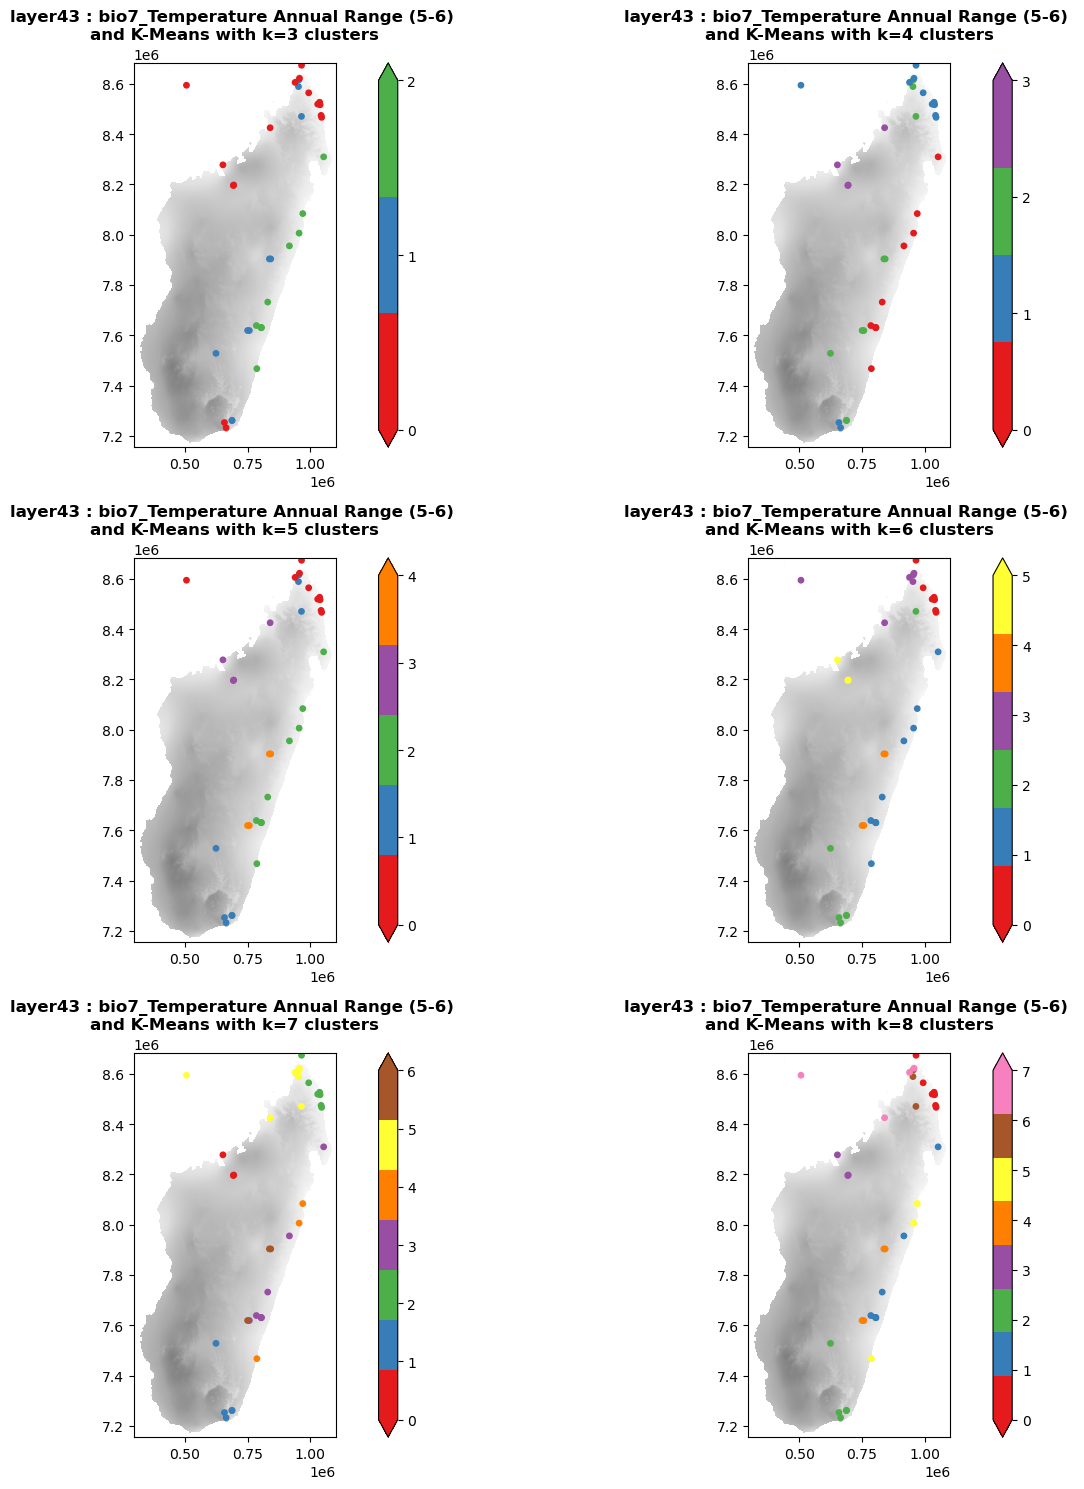

In [250]:
# Scaled data
kmeans_map_plot(X_scaled, 3, 8, 43, gdf_gbs)

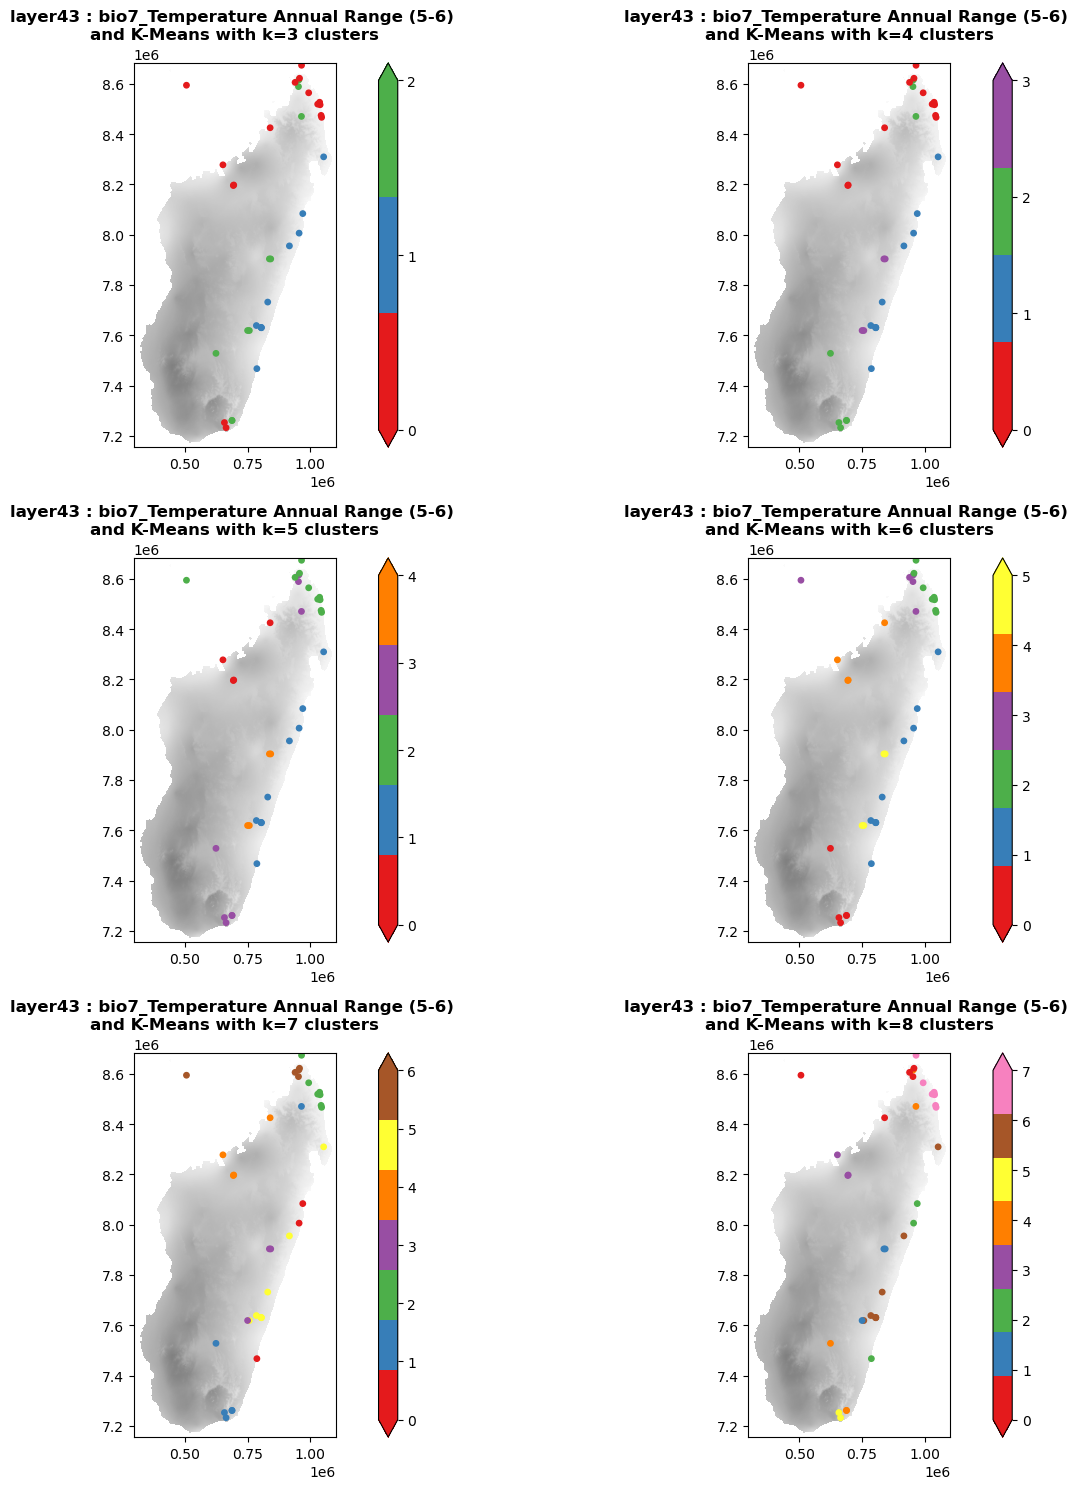

In [251]:
kmeans_map_plot(X_pca, 3, 8, 43, gdf_gbs)

In [252]:
# To validate on the previous map the colors of the clusters
gdf_gbs[["geometry","cluster", "Latitude"]].sort_values(by="Latitude").head(10)

,geometry,cluster,Latitude
Species code,,,
BERT,POINT (664808.037 7232213.963),5,-25.01666
PER1,POINT (658169.137 7252603.015),5,-24.83330
ABA,POINT (688328.240 7260998.023),4,-24.75410
KIA2,POINT (688338.355 7260997.885),4,-24.75410
FAR,POINT (787281.628 7467033.374),2,-22.88000
SAK,POINT (624595.051 7527931.783),4,-22.35000
MIL2,POINT (750334.648 7618740.006),1,-21.51660
LAN,POINT (757247.218 7618631.529),6,-21.51660
MON,POINT (805036.157 7629647.965),6,-21.40970
